# We have Matchfiles! Let's play with them!

Apparently we have matchfiles. Let's take a look where they are.

## Where is the data?

First, we need to find the data?

In [27]:
datadir = "/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/"

### Imports

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

import numpy as np
import pandas as pd
import tables as pt
from FINDflare import FINDflare as ff

import os
from pyinstrument import Profiler

In [29]:
#import sys
#!{sys.executable} -m pip install pyinstrument
# 000592

In [118]:

#fl = '/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/rc00/fr000551-000600/ztf_000592_zr_c01_q1_match_programid2.pytable'
#fl = '/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/rc24/fr000401-000450/ztf_000436_zr_c07_q1_match_programid2.pytable'
#fl = '/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/rc43/fr000401-000450/ztf_000436_zr_c11_q4_match_programid2.pytable'
fl = '/data/epyc/data/ztf_matchfiles/partnership_old_nov18/ztfweb.ipac.caltech.edu/rc37/fr000401-000450/ztf_000436_zr_c10_q2_match_programid2.pytable'
#fl = '/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/rc00/fr000401-000450/ztf_000436_zr_c01_q1_match_programid2.pytable'

In [119]:
fl.split('/')[-1][:-8]


'ztf_000436_zr_c10_q2_match_programid2'

In [120]:
mtfl = pt.open_file(fl, 'r', root_uep='/', filters='lzo')

Let's get the data:

In [121]:
exposures = pd.read_hdf(fl, key="matches/exposures")

In [122]:
sourcedata = pd.read_hdf(fl, key="matches/sourcedata")

In [123]:
#transientdata = pd.read_hdf(fl, key="matches/transientdata")

Some of the entries in the `sources` and `transients` tables are not flat (i.e. there are arrays within a column, which is harder for pandas to deal with without intervention.

Let's load them in following Zach's example:

In [124]:
sourcesObject = mtfl.get_node("/matches", "sources")
transientsObject = mtfl.get_node("/matches", "transients")

In [125]:
sources_columns = pd.DataFrame.from_records(sourcesObject.read(0,0))
sources_columns_list = sources_columns.columns.tolist()
sources = pd.DataFrame.from_records(sourcesObject.cols, columns=sources_columns_list)

In [126]:
transients_columns = pd.DataFrame.from_records(transientsObject.read(0,0))
transients_columns_list = transients_columns.columns.tolist()
transients = pd.DataFrame.from_records(transientsObject.cols, columns=transients_columns_list)

In [127]:
sourcedata.sort_values('mjd', inplace=True)
transientdata.sort_values('mjd', inplace=True)

In [115]:
ids = sources.loc[(sources["matchid"] == 34396), "matchid"]  
s = sourcedata[sourcedata["matchid"] == id]

#idt = transients.loc[(transients["bestmedianmag"] <= 21.5) &  (transients["bestmedianmag"] > 0), "matchid"]  
#idsm = sources.loc[(sources["matchid"] >= 0),'matchid']


In [116]:
def plotflare(file, idf,s,indx, fl='', show=True ):
    fig = plt.figure(figsize=(10, 4.5))
    grid = plt.GridSpec(1, 3, hspace=1, wspace=.5)
    
    ax = fig.add_subplot(grid[0:1, 0:2])
    ax.errorbar(s['mjd'],s['mag'],s['magerr'], marker='o', markersize=3, c="black", alpha=0.15)
    ax.plot(s['mjd'].values[indx],s['mag'].values[indx], linestyle="none",marker='o',markersize=4, c="red")
    ax.set_title(f'Light Curver for ID = {idf}')
    ax.set_ylabel('Magnitude', size=12)
    ax.set_xlabel('Date (MJD)', size=12)
    ax.invert_yaxis()
    
    ax = fig.add_subplot(grid[0:1, 2:3])
    ax.errorbar(s['mjd'],s['mag'],s['magerr'], marker='o', markersize=3, c="black", alpha=0.15)
    ax.plot(s['mjd'].values[indx],s['mag'].values[indx], linestyle="none",marker='o',markersize=4, c="red")
    ax.set_ylabel('Magnitude', size=12)
#    ax.set_xlabel('Date (MJD)', size=12)
    ax.invert_yaxis()
    dur = np.nanmax(s['mjd'].values[indx]) - np.nanmin(s['mjd'].values[indx])    
    ax.set_xlim(np.nanmin(s['mjd'].values[indx]) - 3*dur, np.nanmax(s['mjd'].values[indx]) + 10*dur)
    fig.savefig('images' + '/' + file.split('/')[-1][:-8] + '_id_' + str(idf) + '.png', dpi=300)
    # if flag is true
 #   plt.show()
    # else
   # plt.savefig()
#    plt.close()
#def writedata(idf,nflare):
 #   with open('found_flares.csv','w') as csv_file:
  #  read = csv.reader(csv_file)
   # write = csv.writer(csv_file)
    #write.writerow([idf, nflare])
    

def findflare(file, idf, plot=False, N1=3, N2=1, N3=3):    
    s = sourcedata[sourcedata["matchid"] == idf]
    dt = np.diff(s['mjd'])
    bpoint = np.where((dt > 0.1))[0]
    bpoint += 1
    edges = np.concatenate([[0],bpoint,[len(s)]])
    
    indx = np.array([], dtype=np.int)
    for j in range(len(edges) - 1):
        flare = ff(s['mag'][edges[j]:edges[j+1]],s['magerr'].values[edges[j]:edges[j+1]], N1=N1, N2=N2, N3=N3)
        for i in range(len(flare[0,:])):
            nflare = np.arange(edges[j] + flare[0,i], edges[j] + flare[1,i]+1, 1, dtype=np.int)  
            if len(nflare) > 0:
                plotflare(file,idf,s,nflare)
            elif plot == True :
                plotflare(file,idf,s,nflare)
            indx = np.append(indx, nflare)
            #plot
            #data out


<IPython.core.display.Javascript object>


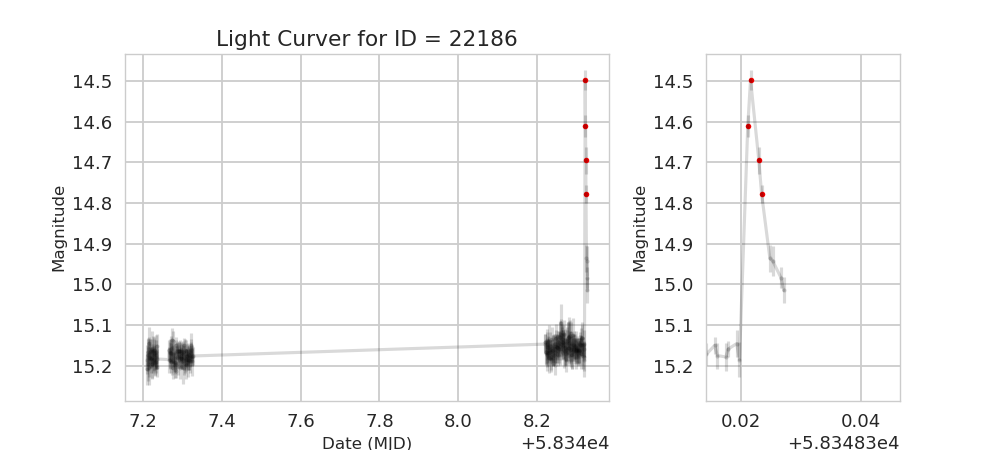

In [128]:
#file =  '/data/epyc/data/ztf_matchfiles/partnership/ztfweb.ipac.caltech.edu/rc00/fr000401-000450/ztf_000436_zr_c01_q1_match_programid2.pytable'
findflare(fl, 22186)

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


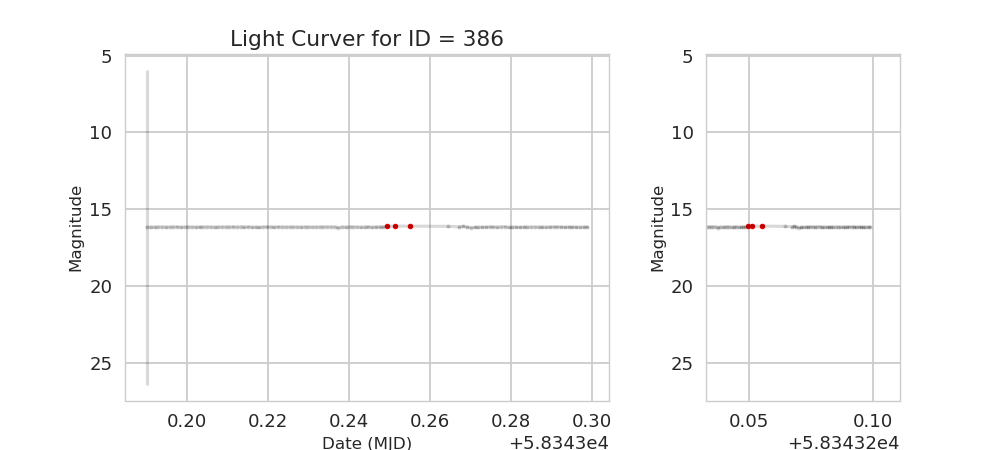

TypeError: savefig() missing 1 required positional argument: 'fname'

In [356]:
%%time
for i in idt:
    findflare(i)

In [ ]:
def EquivDur(time, flux):
    '''
    Compute the Equivalent Duration of an event. This is simply the area
    under the flare, in relative flux units.
    NOTE: sums up all the data given, no start/stop times input. Only
        pass the flare!
    Flux must be array in units of zero-centered RELATIVE FLUX
    Time must be array in units of DAYS
    Output has units of SECONDS
    '''
    p = np.trapz(flux, x=(time * 60.0 * 60.0 * 24.0))
    return p



/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


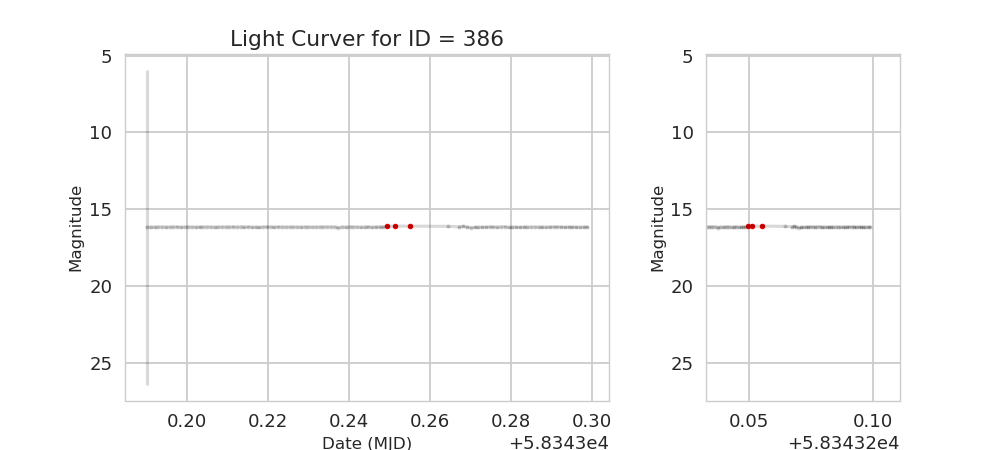

TypeError: savefig() missing 1 required positional argument: 'fname'

In [357]:
%%time 
for i in idt:
    findflare(i)

In [358]:
findflare(51498, N1=2.5,N3=4)

Look at graph id = 114054 There is a ton of spikes in emission in the curve. Only flare found using (2,1,3)

Look at graph id = 110620 (3,1,2), doesnt look too convincing 

one plot per flare, 

Found flares:  69476

i = 110620
s = sourcedata[sourcedata["matchid"] == i]
#print(s['mjd'])
#time =s["mjd"].apply(lambda x: x[1])
#mag = s["psfmag"].apply(lambda x: x[1])


fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(s["mjd"], s["psfmag"],s['psfmagerr'], linestyle="none",marker='o',markersize=5, c="black")
#ax.plot(s["mjd"].apply(lambda x: x[15:17]), s["psfmag"].apply(lambda x: x[15:17]), linestyle="none",marker='o',markersize=10, c="red")
ax.invert_yaxis()
#print(min(s["hjd"])-2458340,max(s["hjd"])-2458340)
#ax.set_xlim(4.7,4.8)

In [ ]:
#sources.columns
#sources.shape
#sources["bestnabovemean5std"] = sources["bestnabovemeanbystd"].apply(lambda x: x[2])
#sources[sources["matchid"] == 103256]
#sources[sources["matchid"] == 69476]
#sources.loc[(sources["bestchisq"]> 1.0) & (sources["bestchisq"]<20.0), "matchid"]
#sources.loc[103256,['ra','dec']]

#profiler=Profiler()
#profiler.start()
#profiler.stop()
#print(profiler.output_text())

#ids3 = sources.loc[sources["bestnabovemean3std"] >= 5, "matchid"]
#ids5 = sources.loc[sources["bestnabovemean5std"] >= 5, "matchid"]
#ids3 = ids[0:len(ids5)]
#sources["bestnabovemean3std"] = sources["bestnabovemeanbystd"].apply(lambda x: x[1])
#sources["bestnabovemean5std"] = sources["bestnabovemeanbystd"].apply(lambda x: x[2])

#%%time
#idm = [110620]
#for i in idm:
#    s = sourcedata[sourcedata["matchid"] == i]
#    dt = np.diff(s['mjd'])
#    bpoint = np.where((dt > 0.1))[0]
#    bpoint += 1
#    edges = np.concatenate([[0],bpoint,[len(s)]])
#    for j in range(len(edges) - 1):
#        flare = ff(s['mag'][edges[j]:edges[j+1]],s['magerr'].values[edges[j]:edges[j+1]],N1=2, N3=5)
#        if flare.shape[1] > 1:
#            print(i)
#            print(flare+edges[j])
#        #PUT NEW PLOT CALL HERE!
#def plotflare(id):
#    s = sourcedata[sourcedata["matchid"] == id]
#    s.sort_values('mjd', inplace=True)
#    flare = ff(s['mag'],s['magerr'],N1=2)
#    indx = np.array([], dtype=np.int)
#    for i in range(len(flare[0,:])):
#        nflare = np.arange(flare[0,0], flare[1,0]+1, 1, dtype=np.int)  
#        indx = np.append(indx, nflare)
#    fig, ax = plt.subplots(1, 1, figsize=(8,4))
#    ax.errorbar(s['mjd'],s['mag'],s['magerr'], marker='o', markersize=3, c="black", alpha=0.15)
#    ax.plot(s['mjd'].values[indx],s['mag'].values[indx], linestyle="none",marker='o',markersize=4, c="red")
#    ax.set_title(f'Light Curver for ID = {id}')
#    ax.set_ylabel('Magnitude')
#    ax.set_xlabel('Date (MJD)')
#    ax.invert_yaxis()

<IPython.core.display.Javascript object>


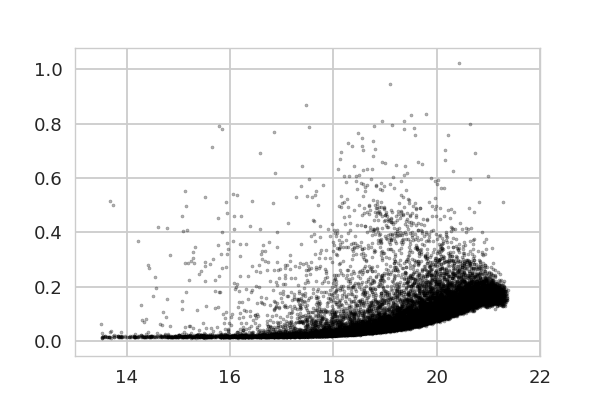

(13, 22)

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(transients[mask]["bestmedianmag"], transients[mask]["bestmagrms"], s=5, alpha=0.3, color="black")

ax.set_xlim(13, 22)

In [33]:
mask = ((transients["nobs"] > 300) & (transients["bestmedianmag"] > 13) & (transients["bestmedianmag"] < 16))

In [ ]:
plt.figure()
plt.hist(sources['nobs'], bins=100)


4

In [34]:
len(mask)

106548

In [35]:
mid_idx = transients[mask][["ra", "dec", "matchid"]].index

In [36]:
mid_idx

Int64Index([3332, 5405, 5441, 6594, 7161, 7180, 7186, 7189, 7925, 7948, 8228,
            8231],
           dtype='int64')

In [37]:
idx = np.random.choice(mid_idx, size=10)

<IPython.core.display.Javascript object>


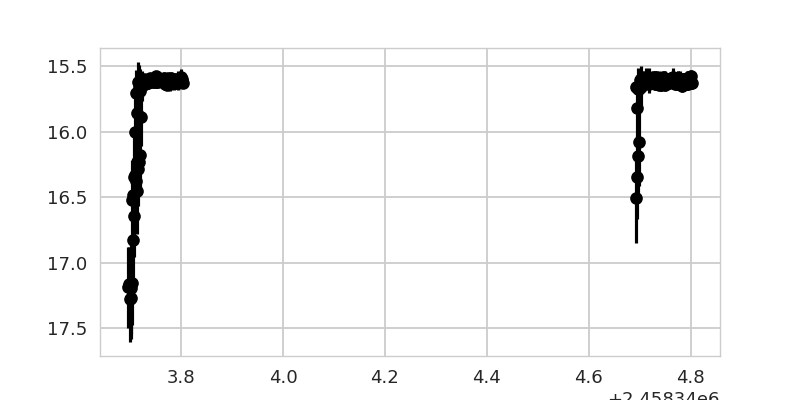

<IPython.core.display.Javascript object>


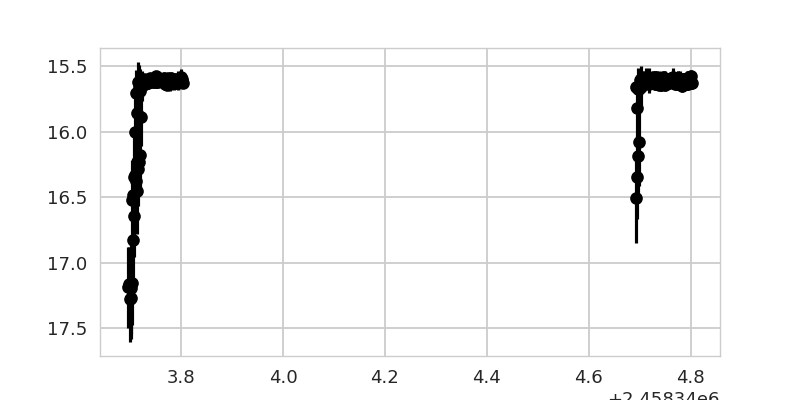

<IPython.core.display.Javascript object>


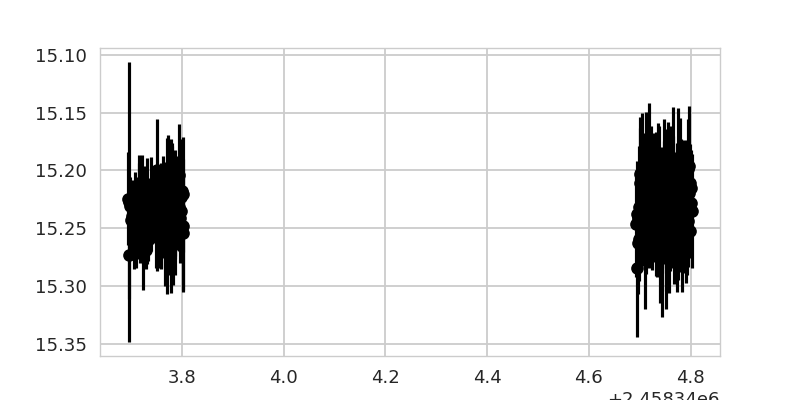

<IPython.core.display.Javascript object>


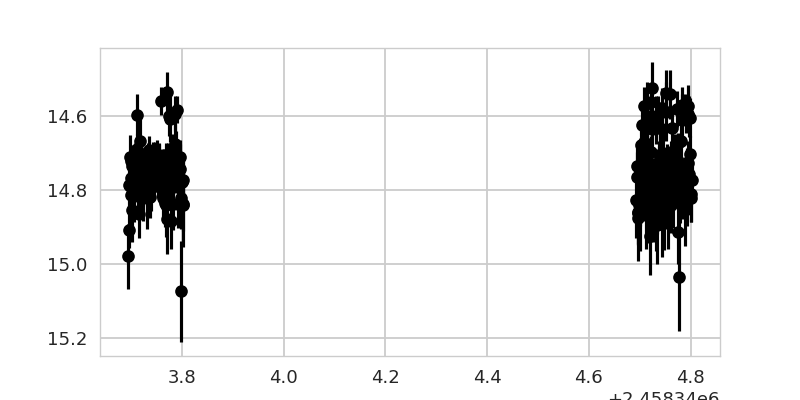

<IPython.core.display.Javascript object>


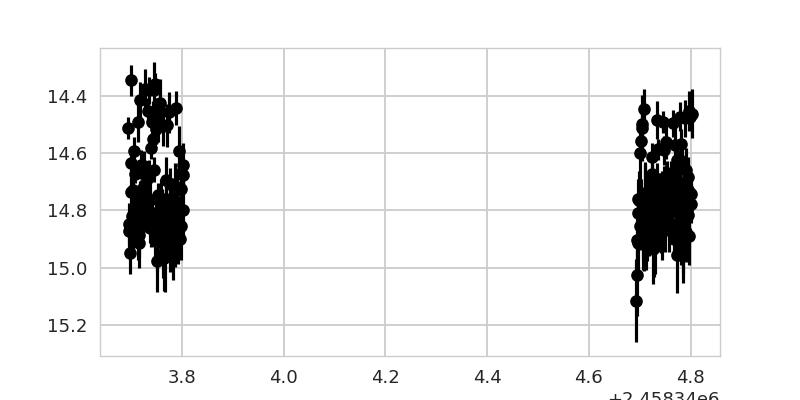

<IPython.core.display.Javascript object>


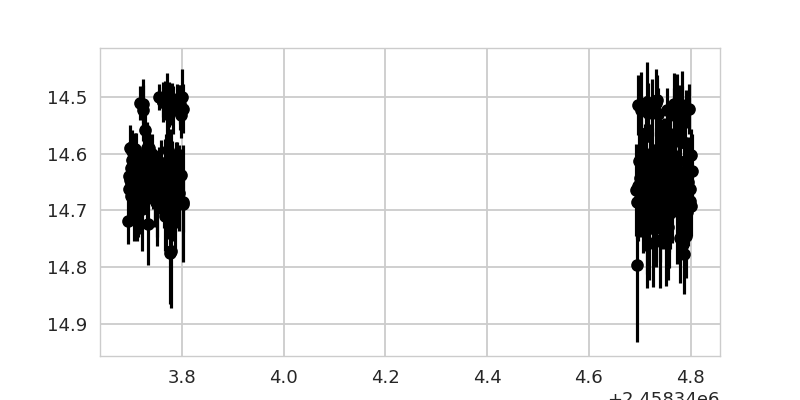

<IPython.core.display.Javascript object>


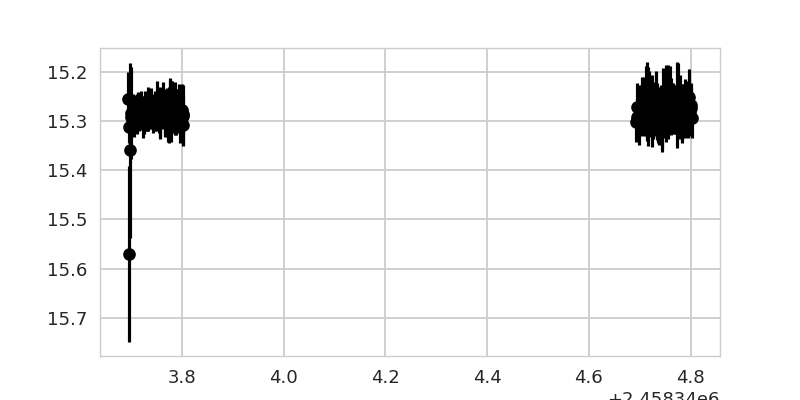

<IPython.core.display.Javascript object>


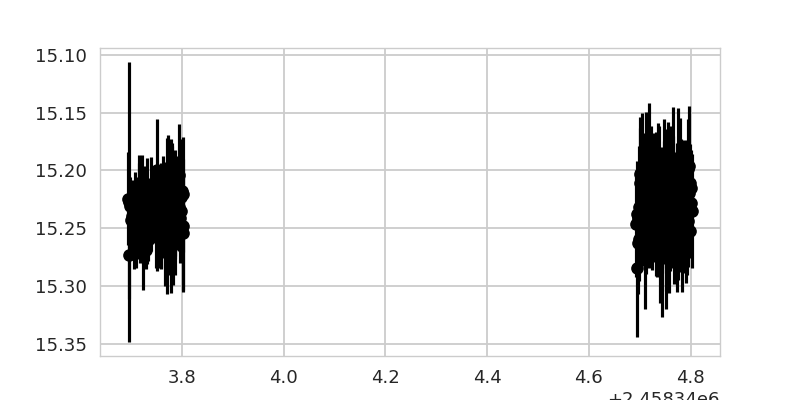

<IPython.core.display.Javascript object>


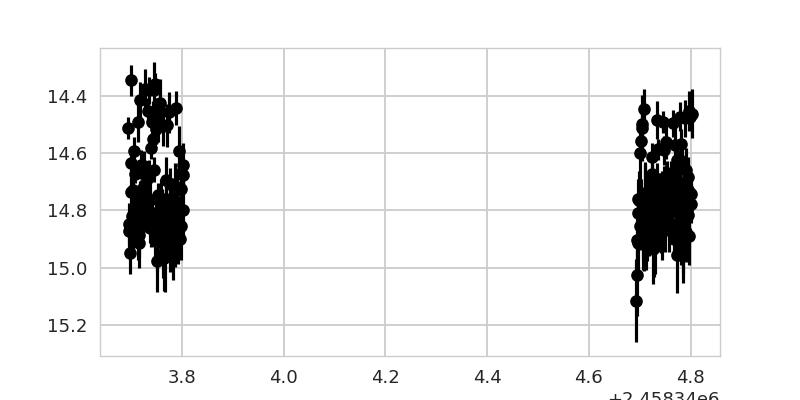

<IPython.core.display.Javascript object>


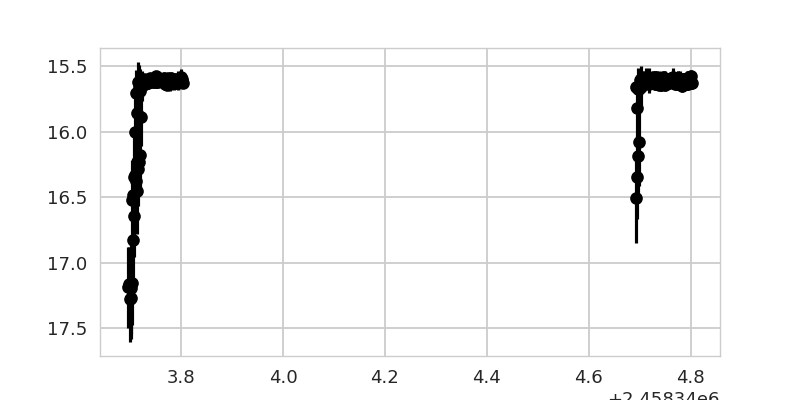

In [38]:
for i in idx:
    s = transientdata[transientdata["matchid"] == i]
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.errorbar(s["hjd"], s["mag"], yerr=s["magerr"], fmt="o", c="black")
    ax.invert_yaxis()

In [39]:
s.columns

Index(['catflags', 'chi', 'dec', 'expid', 'hjd', 'mag', 'magerr', 'matchid',
       'mjd', 'programid', 'psfflux', 'psffluxerr', 'psfmag', 'psfmagerr',
       'ra', 'relphotflags', 'sharp', 'sid', 'snr', 'x', 'xpos', 'y', 'ypos',
       'z'],
      dtype='object')

<IPython.core.display.Javascript object>


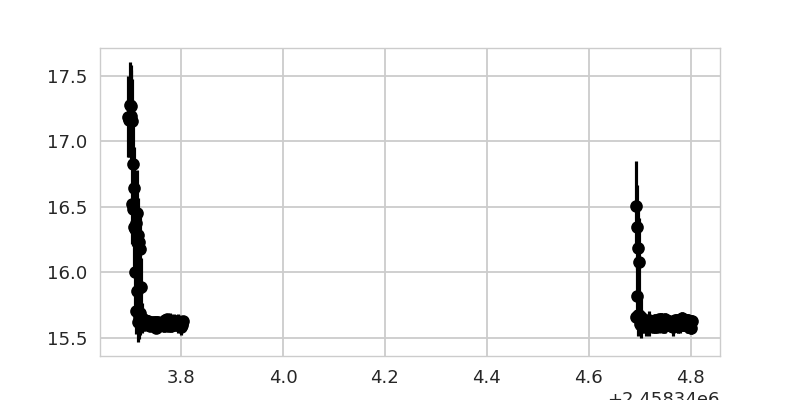

<ErrorbarContainer object of 3 artists>

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.errorbar(s["hjd"], s["mag"], yerr=s["magerr"], fmt="o", c="black")

<IPython.core.display.Javascript object>


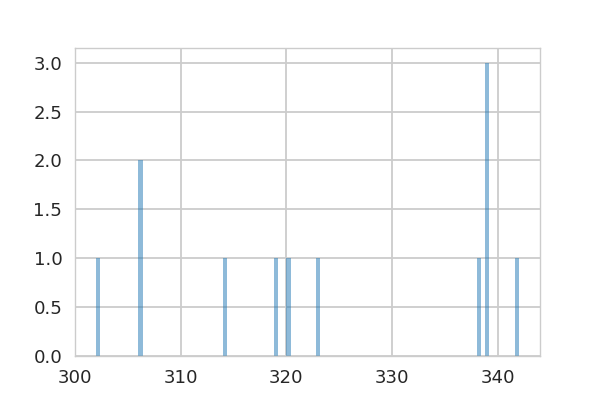

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(transients[mask]["nobs"], bins=100, histtype="stepfilled", alpha=0.5);

<IPython.core.display.Javascript object>


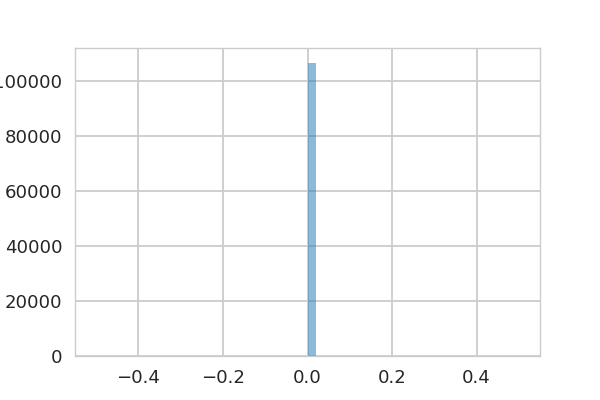

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(transients["refmag"], bins=50, histtype="stepfilled", alpha=0.5);

In [122]:
transients[mask]["matchid"]

54        54
519      519
914      914
922      922
1357    1357
1391    1391
1432    1432
1470    1470
1518    1518
1539    1539
1548    1548
1643    1643
1707    1707
1727    1727
1898    1898
1910    1910
1940    1940
Name: matchid, dtype: int64

In [127]:
transients.columns

Index(['astrometricrms', 'bestastrometricrms', 'bestchisq', 'bestcon',
       'bestlineartrend', 'bestmagrms', 'bestmaxmag', 'bestmaxslope',
       'bestmeanmag', 'bestmedianabsdev', 'bestmedianmag', 'bestminmag',
       'bestnabovemeanbystd', 'bestnbelowmeanbystd',
       'bestnconsecabovemeanbystd', 'bestnconsecbelowmeanbystd',
       'bestnconsecfrommeanbystd', 'bestnmedianbufferrange',
       'bestnpairposslope', 'bestpercentiles', 'bestperiodsearch',
       'bestprobnonqso', 'bestprobqso', 'bestskewness', 'bestsmallkurtosis',
       'beststetsonj', 'beststetsonk', 'bestvonneumannratio',
       'bestweightedmagrms', 'bestweightedmeanmag', 'chisq', 'con', 'dec',
       'lineartrend', 'magrms', 'matchid', 'maxmag', 'maxslope', 'meanmag',
       'medianabsdev', 'medianmag', 'minmag', 'nabovemeanbystd',
       'nbelowmeanbystd', 'nbestobs', 'nconsecabovemeanbystd',
       'nconsecbelowmeanbystd', 'nconsecfrommeanbystd', 'ngoodobs',
       'nmedianbufferrange', 'nobs', 'npairposslope', 

In [126]:
transients[transients["matchid"] == 1470]["nobs"]

1470    202
Name: nobs, dtype: int64

In [124]:
len(transientdata[transientdata["matchid"] == 1470])

175

Lessons:
* the `sources` table and the `transients` table contain summaries derived from *all* measurements and exposures, across all programmes (this is why `nobs` in these tables does not match up with the number of data points per `matchid` in the `transientdata` and the `sourcedata` tables)
* the `sourcedata` and `transientdata` table contain *only* partnership data
* there are entries in the `sources` table that have `nobs`== 0 (i.e. no observations), for which the summaries in the `sources` table are not meaningful (e.g. median magnitudes of -1000 or +3000). These are entries of sources that are in the reference catalogue, but too faint to be observed with ZTF
* You can look at the magnitude in the reference catalogue with `refmag`. For the `transients` table, `refmag` is zero for all entries, because this table contains all newly detected sources that are *not* in the reference catalogue
* Once we cut on `nobs > 0`, the plots of median magnitude versus rms look much better :) 
* `sourcedata` and `transientsdata` tables do not have the filter IDs given; we need to cross them with the exposures table to figure out which measurements come from which filter!
* There are a whole bunch of bright sources (we counted ~500 in one quadrant with >50 measurements) in the `transients` table that are not variable (or only a little bit variable). We don't understand why those sources aren't in the reference catalogue (but are in PanSTARRS)

Let's play around with the source data:

In [46]:
sourcedata.columns

Index(['catflags', 'chi', 'dec', 'expid', 'hjd', 'mag', 'magerr', 'matchid',
       'mjd', 'programid', 'psfflux', 'psffluxerr', 'psfmag', 'psfmagerr',
       'ra', 'relphotflags', 'sharp', 'sid', 'snr', 'x', 'xpos', 'y', 'ypos',
       'z'],
      dtype='object')

In [47]:
ndatapoints = sourcedata.groupby("matchid").apply(len)

In [48]:
ndatapoints.sort_values()[::-1].head()

matchid
65772    235
94920    235
94916    235
94915    235
94913    235
dtype: int64

In [49]:
s = sources.loc[sources["matchid"] == 27337]

In [50]:
s.columns

Index(['astrometricrms', 'bestastrometricrms', 'bestchisq', 'bestcon',
       'bestlineartrend', 'bestmagrms', 'bestmaxmag', 'bestmaxslope',
       'bestmeanmag', 'bestmedianabsdev', 'bestmedianmag', 'bestminmag',
       'bestnabovemeanbystd', 'bestnbelowmeanbystd',
       'bestnconsecabovemeanbystd', 'bestnconsecbelowmeanbystd',
       'bestnconsecfrommeanbystd', 'bestnmedianbufferrange',
       'bestnpairposslope', 'bestpercentiles', 'bestperiodsearch',
       'bestprobnonqso', 'bestprobqso', 'bestskewness', 'bestsmallkurtosis',
       'beststetsonj', 'beststetsonk', 'bestvonneumannratio',
       'bestweightedmagrms', 'bestweightedmeanmag', 'chisq', 'con', 'dec',
       'lineartrend', 'magrms', 'matchid', 'maxmag', 'maxslope', 'meanmag',
       'medianabsdev', 'medianmag', 'minmag', 'nabovemeanbystd',
       'nbelowmeanbystd', 'nbestobs', 'nconsecabovemeanbystd',
       'nconsecbelowmeanbystd', 'nconsecfrommeanbystd', 'ngoodobs',
       'nmedianbufferrange', 'nobs', 'npairposslope', 

In [51]:
s["nobs"]

27337    343
Name: nobs, dtype: int64

In [52]:
s["nbestobs"]

27337    337
Name: nbestobs, dtype: int64

In [55]:
source = sourcedata.loc[sourcedata["matchid"] == 27337]

In [56]:
source.head()

catflags    chi        dec     expid           hjd        mag  \
5764806         0  1.412  16.480009  58920449  2.458344e+06  17.518364   
5764807         0  1.693  16.479992  59021642  2.458345e+06  17.520603   
5764808         0  0.693  16.479986  58923968  2.458344e+06  17.525991   
5764809         0  1.275  16.479987  58922115  2.458344e+06  17.543161   
5764810         0  0.441  16.480000  58923135  2.458344e+06  17.526354   

           magerr  matchid           mjd  programid    ...             ra  \
5764806  0.043604    27337  58343.204491          2    ...     299.060293   
5764807  0.048595    27337  58344.216424          2    ...     299.060279   
5764808  0.025458    27337  58343.239687          2    ...     299.060290   
5764809  0.042836    27337  58343.221157          2    ...     299.060295   
5764810  0.022863    27337  58343.231354          2    ...     299.060293   

         relphotflags  sharp    sid        snr         x         xpos       y  \
5764806             0 -0.077  69841  25.549999  0.465775  2906.896973 -0.8382   
5764807             0 -0.008  28841  22.430000  0.465775  2909.712891 -0.8382   
5764808             0 -0.030  81836  44.139999  0.465775  2910.851074 -0.8382   
5764809             0 -0.090  27886  26.040001  0.465775  2908.071045 -0.8382   
5764810             0  0.019  85648  50.029999  0.465775  2909.216064 -0.8382   

                ypos         z  
5764806  1680.729980  0.283681  
5764807  1819.963013  0.283680  
5764808  1684.878052  0.283680  
5764809  1683.618042  0.283680  
5764810  1684.677002  0.283681  

[5 rows x 24 columns]

In [57]:
source.columns

Index(['catflags', 'chi', 'dec', 'expid', 'hjd', 'mag', 'magerr', 'matchid',
       'mjd', 'programid', 'psfflux', 'psffluxerr', 'psfmag', 'psfmagerr',
       'ra', 'relphotflags', 'sharp', 'sid', 'snr', 'x', 'xpos', 'y', 'ypos',
       'z'],
      dtype='object')

<IPython.core.display.Javascript object>


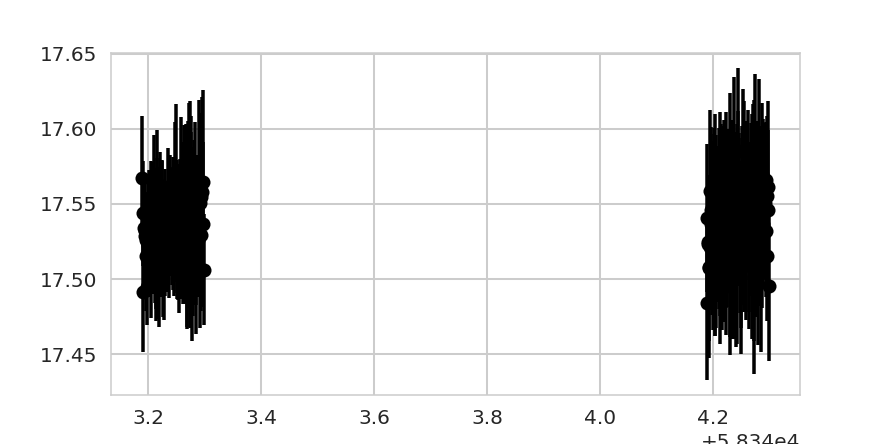

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(source["mjd"], source["psfmag"], yerr=source["psfmagerr"], 
            fmt="o", color="black");

In [124]:
sources.loc[sources["medianmag"] < 0, "medianmag"]

5                -inf
37      -2.342410e-01
60               -inf
139              -inf
146              -inf
163              -inf
191              -inf
239     -1.999159e+37
290     -8.299901e-01
382     -1.139352e-33
426              -inf
459              -inf
562              -inf
609              -inf
622     -1.040644e+07
647     -2.429308e-01
683     -9.098404e+06
754     -1.236912e-12
827              -inf
830     -2.361438e-01
930     -5.465297e+26
991              -inf
1049    -8.871392e+06
1144    -8.313286e-01
1179             -inf
1204    -4.789467e+16
1225             -inf
1244             -inf
1263             -inf
1421             -inf
             ...     
29487            -inf
29500   -2.452079e-01
29535            -inf
29544            -inf
29565            -inf
29596            -inf
29619            -inf
29622   -2.374253e-01
29631   -8.308748e-01
29635            -inf
29641   -1.999159e+37
29683   -2.408505e-01
29692   -8.303484e-01
29716            -inf
29719   -8

So this is weird?

In [59]:
sources.loc[sources["bestmedianmag"] < 0, "bestmedianmag"]

Series([], Name: bestmedianmag, dtype: float64)

In [60]:
mask = ((sources["nobs"] > 0))#((sources["bestmedianmag"] > 5000))
#mask2 = ((sources["bestmedianmag"] > 0) & (sources["beststetsonj"] > 0.5) & (sources["bestmedianmag"] < 21))

In [61]:
sources.columns

Index(['astrometricrms', 'bestastrometricrms', 'bestchisq', 'bestcon',
       'bestlineartrend', 'bestmagrms', 'bestmaxmag', 'bestmaxslope',
       'bestmeanmag', 'bestmedianabsdev', 'bestmedianmag', 'bestminmag',
       'bestnabovemeanbystd', 'bestnbelowmeanbystd',
       'bestnconsecabovemeanbystd', 'bestnconsecbelowmeanbystd',
       'bestnconsecfrommeanbystd', 'bestnmedianbufferrange',
       'bestnpairposslope', 'bestpercentiles', 'bestperiodsearch',
       'bestprobnonqso', 'bestprobqso', 'bestskewness', 'bestsmallkurtosis',
       'beststetsonj', 'beststetsonk', 'bestvonneumannratio',
       'bestweightedmagrms', 'bestweightedmeanmag', 'chisq', 'con', 'dec',
       'lineartrend', 'magrms', 'matchid', 'maxmag', 'maxslope', 'meanmag',
       'medianabsdev', 'medianmag', 'minmag', 'nabovemeanbystd',
       'nbelowmeanbystd', 'nbestobs', 'nconsecabovemeanbystd',
       'nconsecbelowmeanbystd', 'nconsecfrommeanbystd', 'ngoodobs',
       'nmedianbufferrange', 'nobs', 'npairposslope', 

In [87]:
sourcedata.columns

Index(['catflags', 'chi', 'dec', 'expid', 'hjd', 'mag', 'magerr', 'matchid',
       'mjd', 'programid', 'psfflux', 'psffluxerr', 'psfmag', 'psfmagerr',
       'ra', 'relphotflags', 'sharp', 'sid', 'snr', 'x', 'xpos', 'y', 'ypos',
       'z'],
      dtype='object')

In [94]:
mask_nobs = (sources["nobs"]>0)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


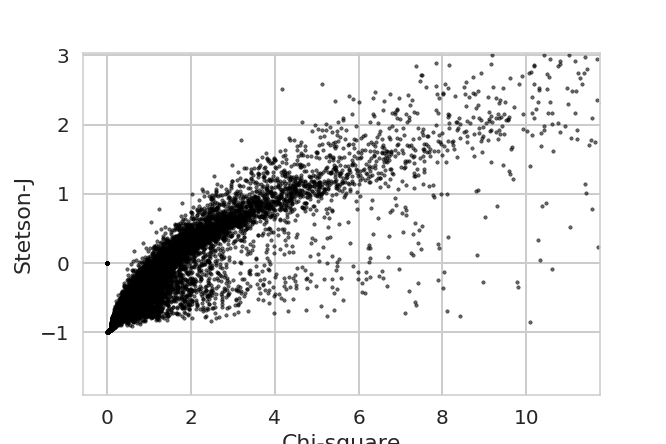

Text(0,0.5,'Stetson-J')

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(sources[mask_nobs]["bestchisq"], sources[mask_nobs]["beststetsonj"], s=5, c='black', alpha=0.6)
ax.set_xlabel("Chi-square")
ax.set_ylabel("Stetson-J")

In [62]:
len(sources[mask])

131981

In [63]:
len(sources)

132328

<IPython.core.display.Javascript object>


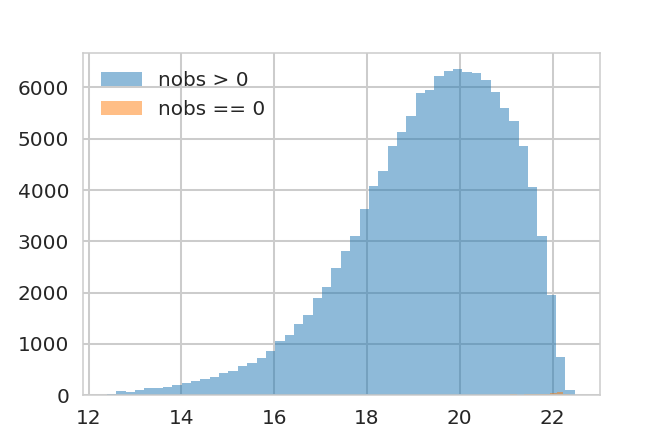

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(sources[mask]["refmag"], bins=50, alpha=0.5, histtype="stepfilled", label="nobs > 0");
ax.hist(sources[~mask]["refmag"], bins=50, alpha=0.5, histtype="stepfilled", label="nobs == 0");
ax.legend(loc="upper left")

<IPython.core.display.Javascript object>


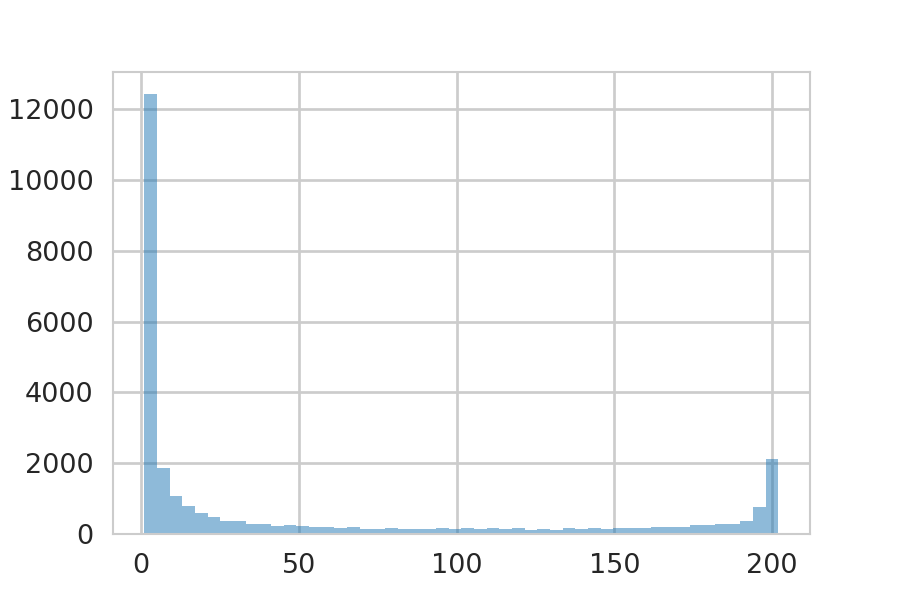

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(sources[mask]["nobs"], bins=50, alpha=0.5, histtype="stepfilled");

<IPython.core.display.Javascript object>


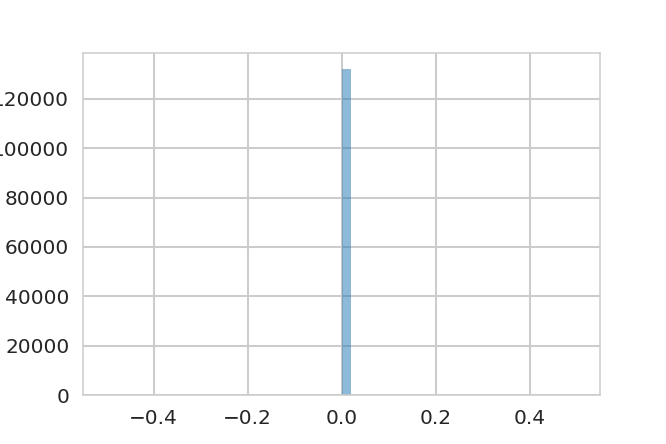

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0., 131981.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <a list of 1 Patch objects>)

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(sources[mask]["nobs"]-sources[mask]["ngoodobs"], bins=50, alpha=0.5, histtype="stepfilled")

<IPython.core.display.Javascript object>


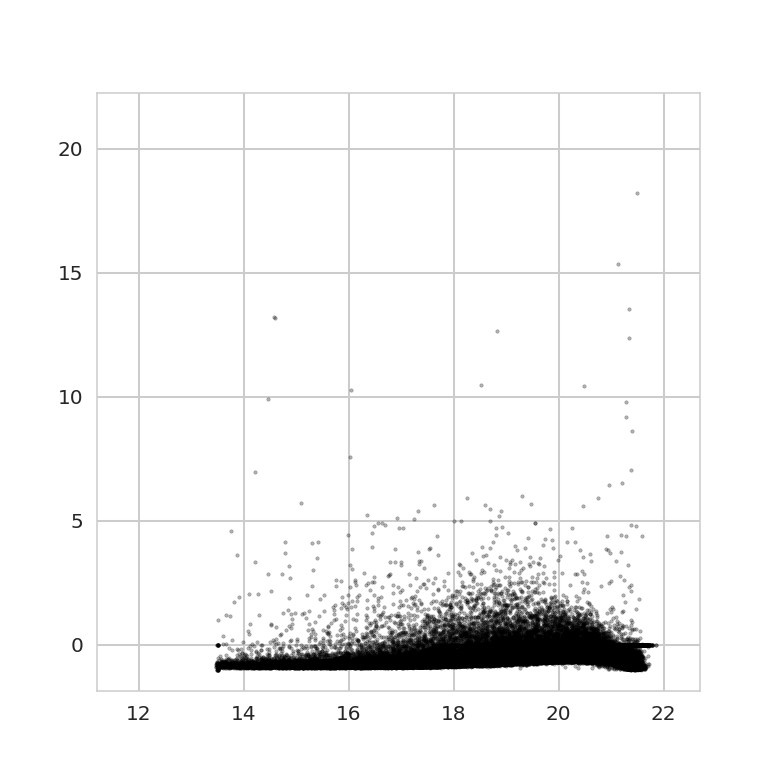

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.scatter(sources["bestmedianmag"][mask], 
           sources["beststetsonj"][mask], marker="o", s=5, color="black", alpha=0.3)

#ax.scatter(sources["bestmedianmag"][mask2], 
#           sources["bestmagrms"][mask2], marker="o", s=5, color="red", alpha=0.7)

#ax.set_xlim(13, 22)
#ax.set_ylim(0, 1.5)

In [114]:
mask = ((sources["nobs"] > 100) & (sources["beststetsonj"] > 3))

In [115]:
np.sum(mask)

80

In [124]:
sources[mask]["matchid"].values

array([   428,   5202,   5223,   7324,   9190,  10445,  14652,  24602,
        25202,  27033,  27170,  28895,  34286,  35312,  37036,  37960,
        38600,  40450,  42334,  43862,  44327,  44731,  46232,  48458,
        48656,  51805,  54314,  56292,  59226,  60388,  63461,  65256,
        66472,  68436,  69272,  69476,  75510,  76025,  76885,  79011,
        81743,  85399,  86180,  86316,  87291,  87365,  88596,  88729,
        92148,  93850,  98980, 100630, 102911, 106183, 108549, 109707,
       110514, 112437, 113945, 114039, 115153, 116759, 116775, 119461,
       120785, 121540, 121552, 121864, 125720, 126467, 127447, 128285,
       128806, 130289, 131060, 131380, 131679, 131703, 131860, 132209])

In [125]:
var_sourcedata = pd.merge(sourcedata, sources[mask], left_on="matchid", right_index=True, how="inner")

In [127]:
var_sourcedata["matchid"].unique()

array([   428,   5202,   5223,   7324,   9190,  10445,  14652,  24602,
        25202,  27033,  27170,  28895,  34286,  35312,  37036,  37960,
        38600,  40450,  42334,  43862,  44327,  44731,  46232,  48458,
        48656,  51805,  54314,  56292,  59226,  60388,  63461,  65256,
        66472,  68436,  69272,  69476,  75510,  76025,  76885,  79011,
        81743,  85399,  86180,  86316,  87291,  87365,  88596,  88729,
        92148,  93850,  98980, 100630, 102911, 106183, 108549, 109707,
       110514, 112437, 113945, 114039, 115153, 116759, 116775, 119461,
       120785, 121540, 121552, 121864, 125720, 126467, 127447, 128285,
       128806, 130289, 131060, 131380, 131679, 131703, 131860, 132209])

In [131]:
var_source_mean = var_sourcedata.groupby("matchid").agg(np.mean)

In [132]:
var_source_mean.columns

Index(['catflags', 'chi', 'dec_x', 'expid', 'hjd', 'mag', 'magerr',
       'matchid_x', 'mjd', 'programid', 'psfflux', 'psffluxerr', 'psfmag',
       'psfmagerr', 'ra_x', 'relphotflags', 'sharp', 'sid', 'snr', 'x_x',
       'xpos', 'y_x', 'ypos', 'z_x', 'astrometricrms', 'bestastrometricrms',
       'bestchisq', 'bestcon', 'bestlineartrend', 'bestmagrms', 'bestmaxmag',
       'bestmaxslope', 'bestmeanmag', 'bestmedianabsdev', 'bestmedianmag',
       'bestminmag', 'bestnmedianbufferrange', 'bestnpairposslope',
       'bestprobnonqso', 'bestprobqso', 'bestskewness', 'bestsmallkurtosis',
       'beststetsonj', 'beststetsonk', 'bestvonneumannratio',
       'bestweightedmagrms', 'bestweightedmeanmag', 'chisq', 'con', 'dec_y',
       'lineartrend', 'magrms', 'matchid_y', 'maxmag', 'maxslope', 'meanmag',
       'medianabsdev', 'medianmag', 'minmag', 'nbestobs', 'ngoodobs',
       'nmedianbufferrange', 'nobs', 'npairposslope', 'probnonqso', 'probqso',
       'ra_y', 'refchi', 'refmag', 'refmag

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


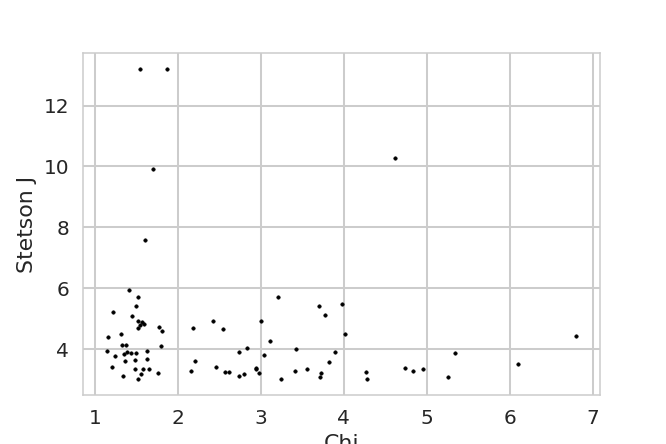

Text(0,0.5,'Stetson J')

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(var_source_mean["chi"], var_source_mean["beststetsonj"], s=5, c="black")

ax.set_xlabel("Chi")
ax.set_ylabel("Stetson J")

1.2423574


<IPython.core.display.Javascript object>


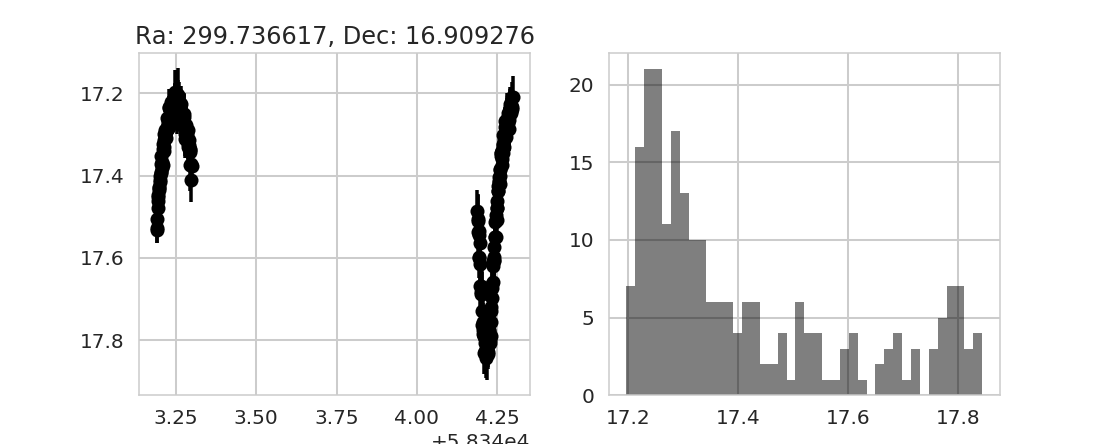

1.3788085


<IPython.core.display.Javascript object>


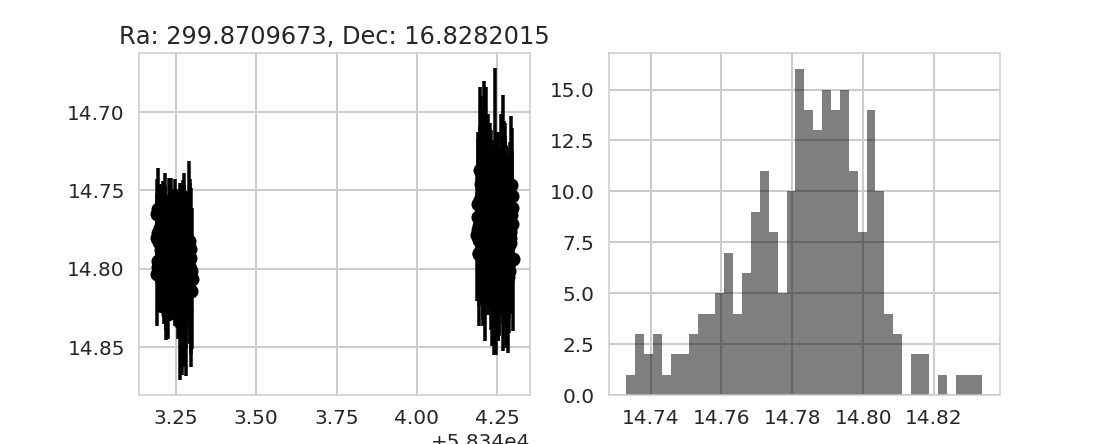

1.7600085


<IPython.core.display.Javascript object>


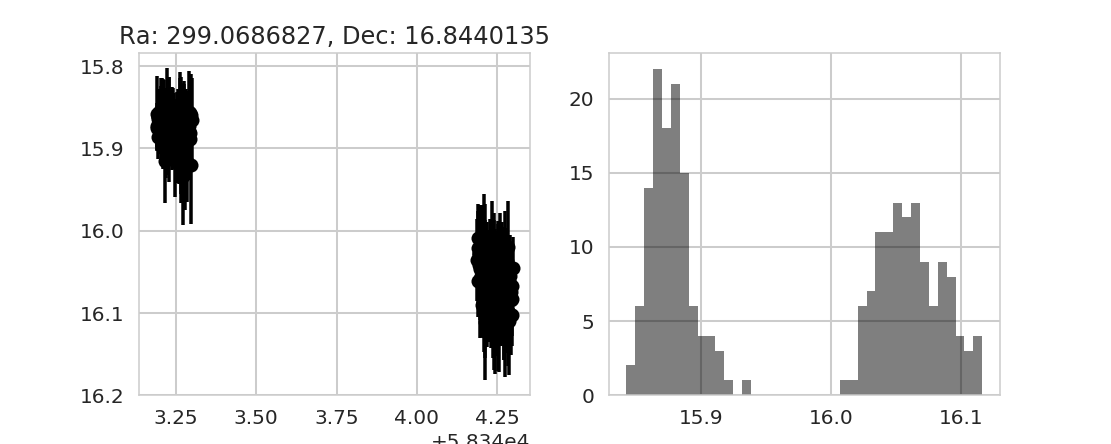

1.5444936


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


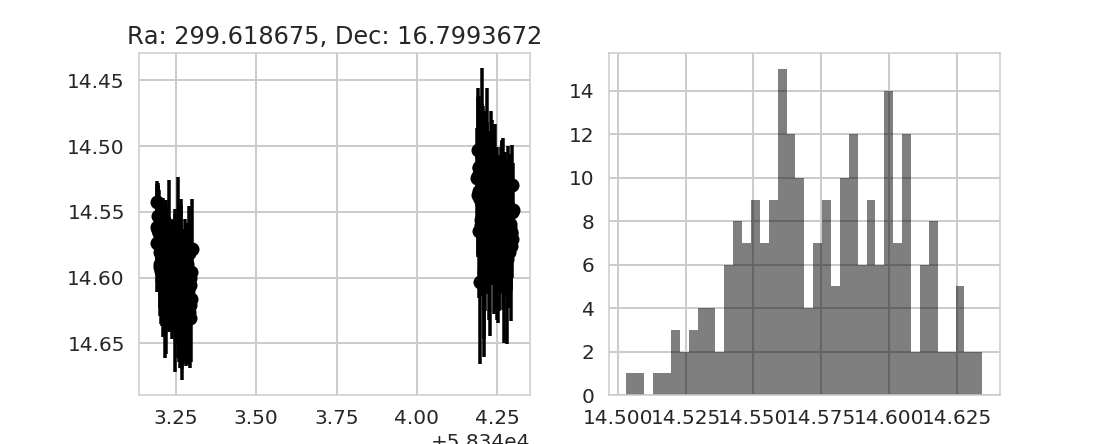

1.331417


<IPython.core.display.Javascript object>


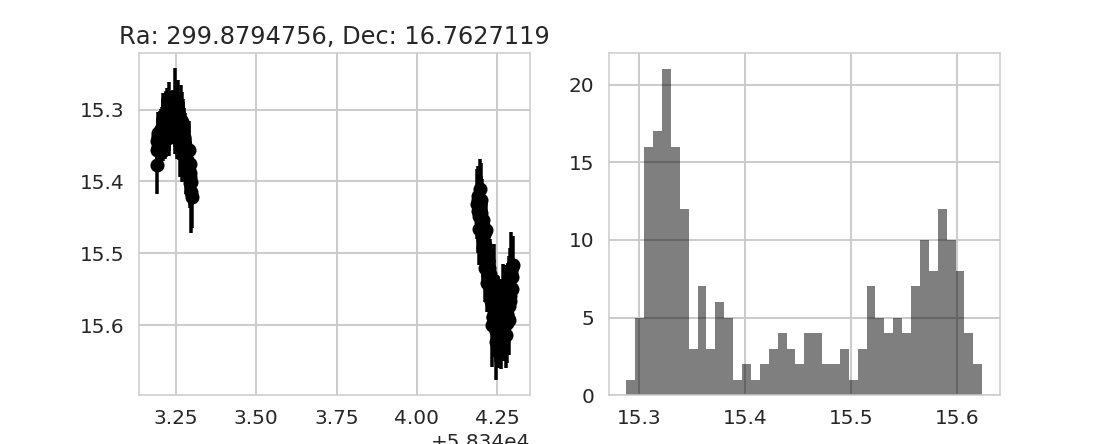

1.3659787


<IPython.core.display.Javascript object>


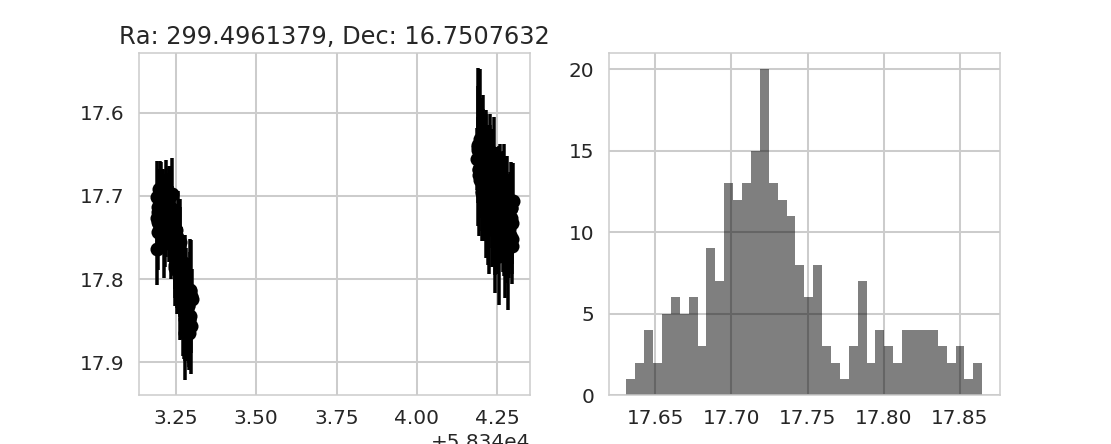

1.1530169


<IPython.core.display.Javascript object>


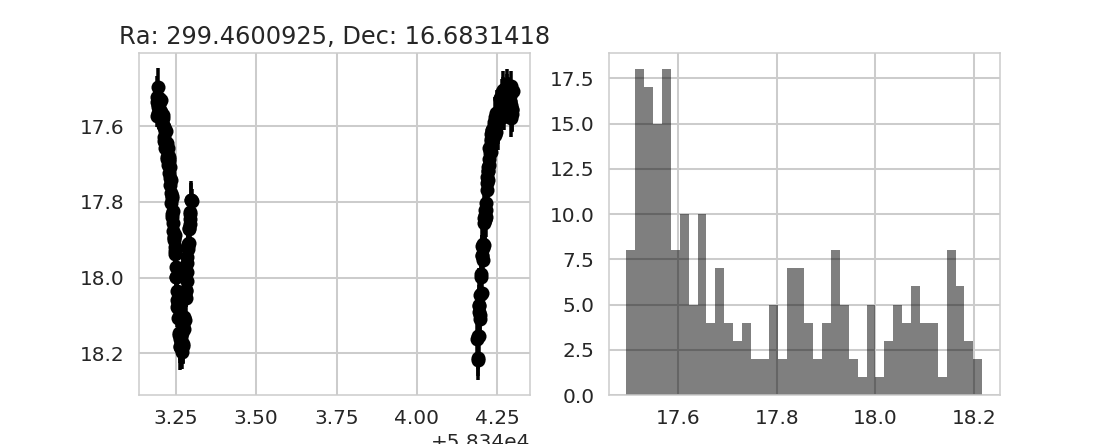

1.5444554


<IPython.core.display.Javascript object>


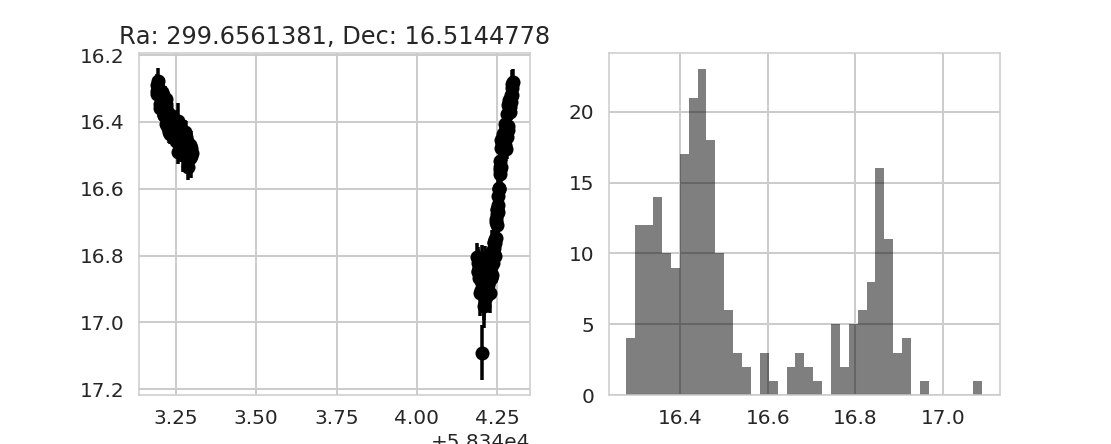

1.4468852


<IPython.core.display.Javascript object>


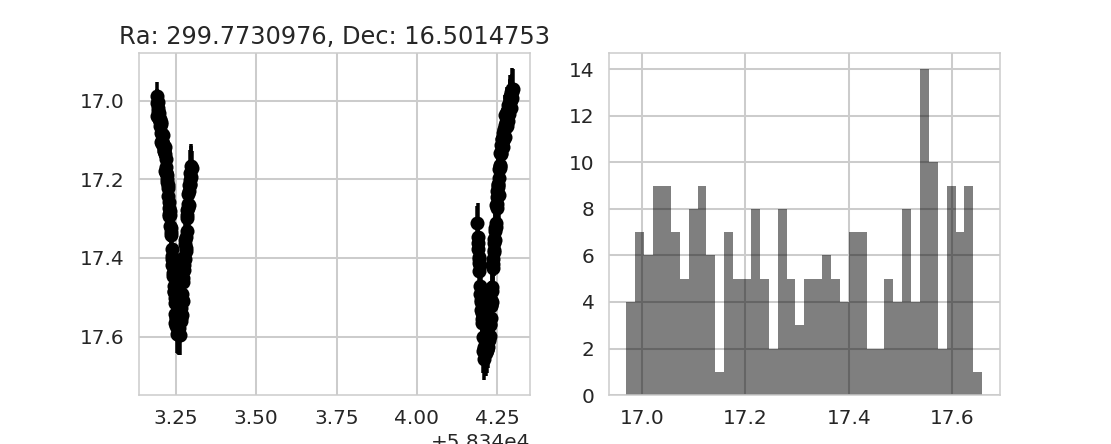

1.7744657


<IPython.core.display.Javascript object>


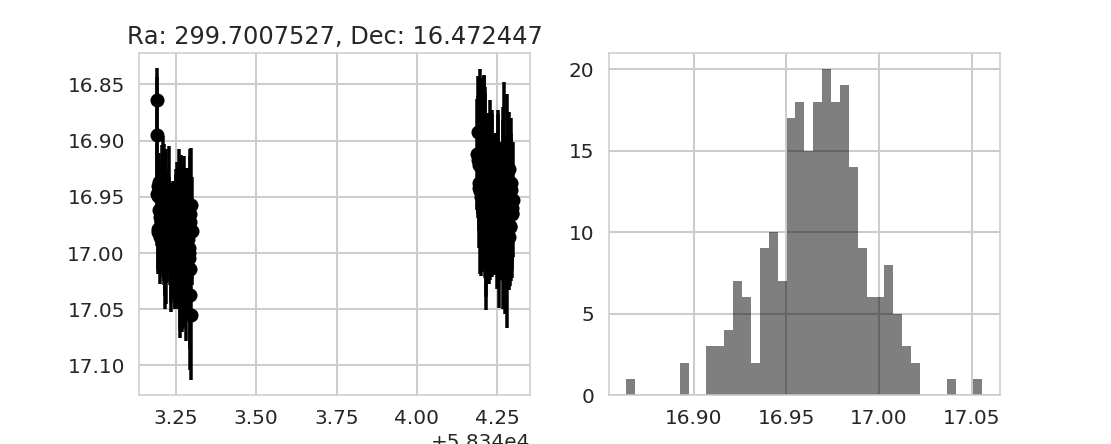

1.5900764


<IPython.core.display.Javascript object>


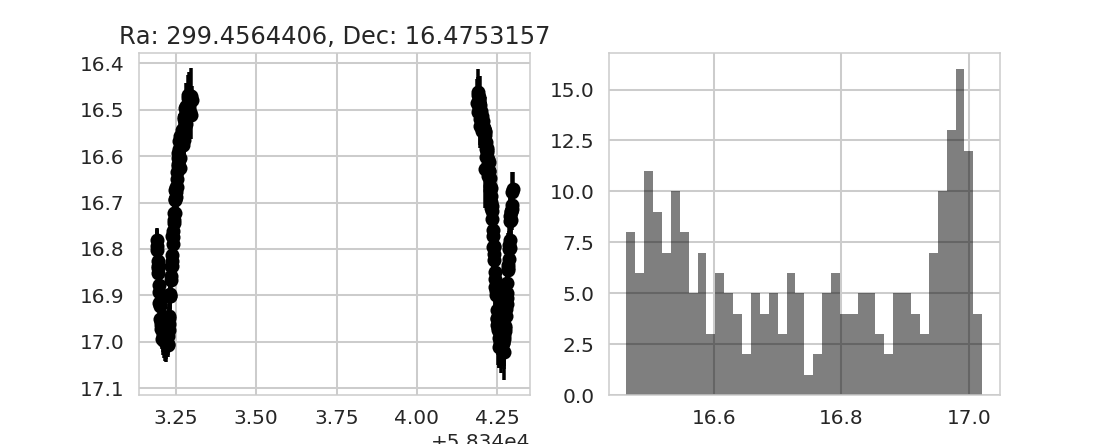

1.5142043


<IPython.core.display.Javascript object>


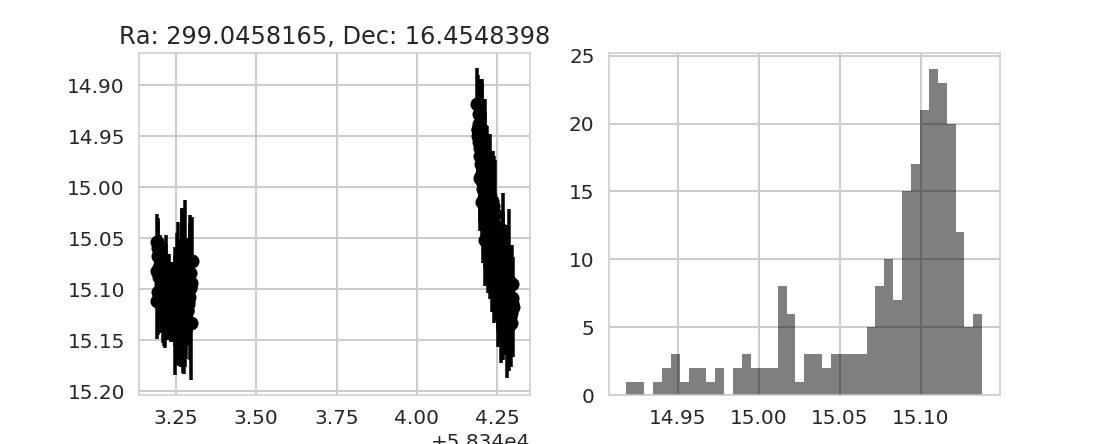

1.8629528


<IPython.core.display.Javascript object>


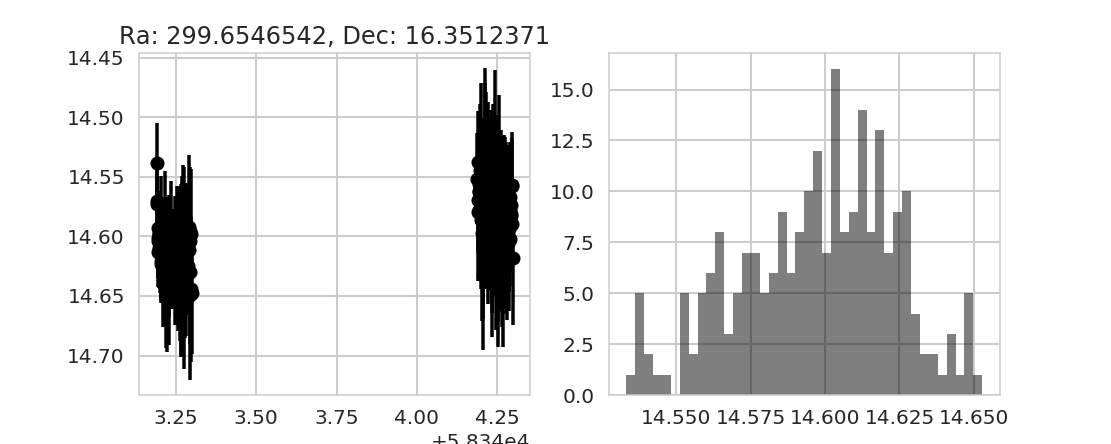

1.5215278


<IPython.core.display.Javascript object>


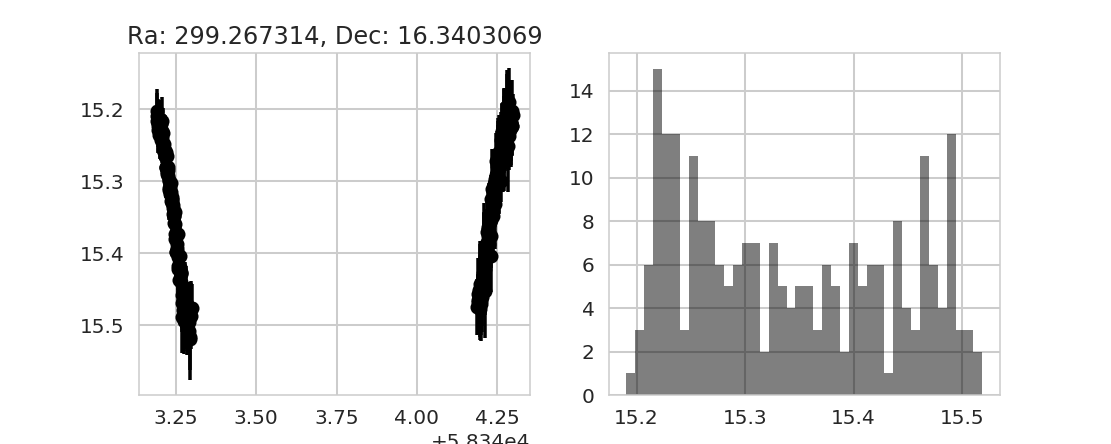

1.8042254


<IPython.core.display.Javascript object>


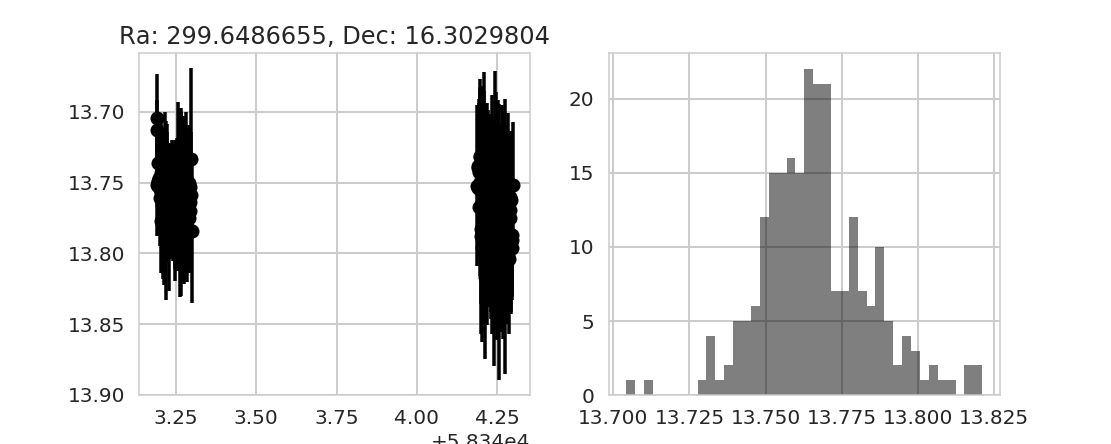

1.4382807


<IPython.core.display.Javascript object>


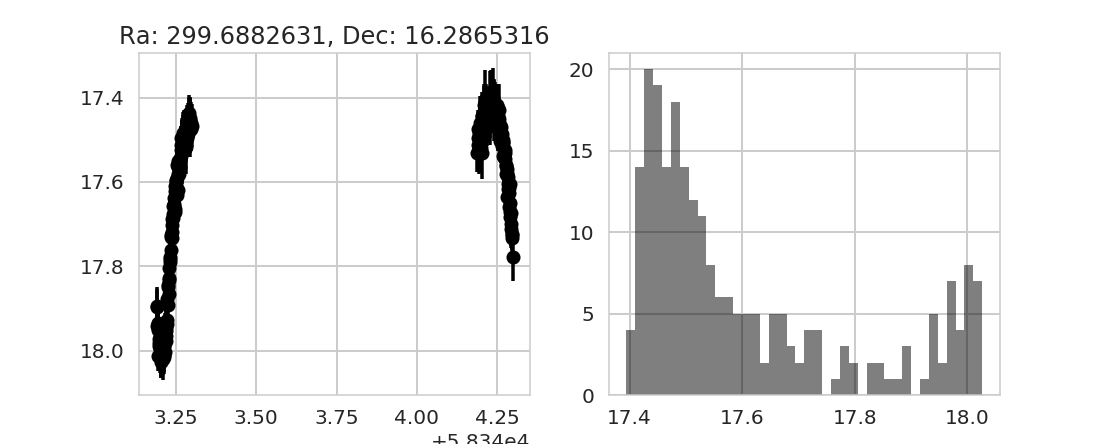

1.6267405


<IPython.core.display.Javascript object>


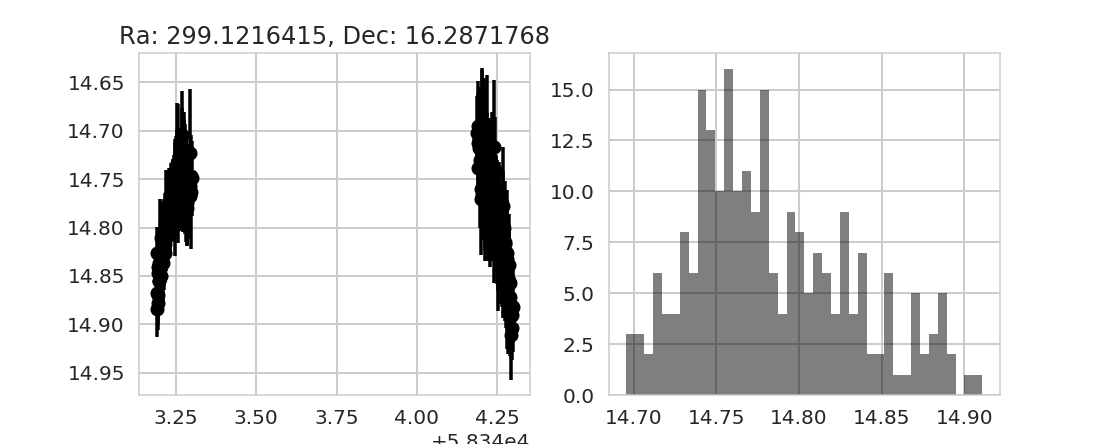

1.6985064


<IPython.core.display.Javascript object>


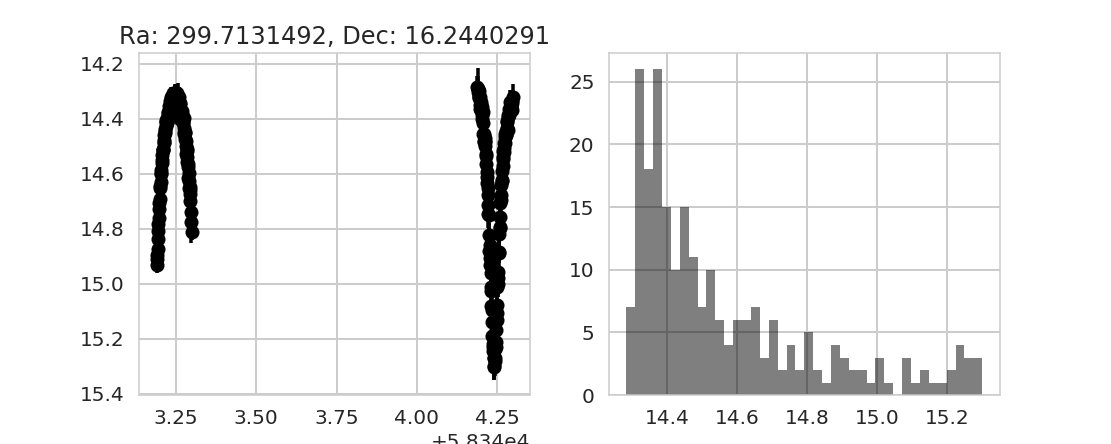

1.6301106


<IPython.core.display.Javascript object>


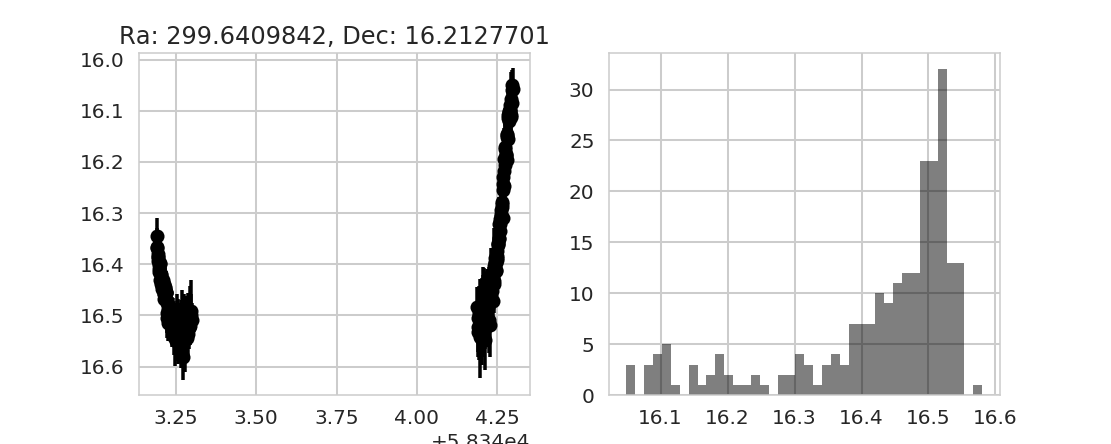

1.4915364


<IPython.core.display.Javascript object>


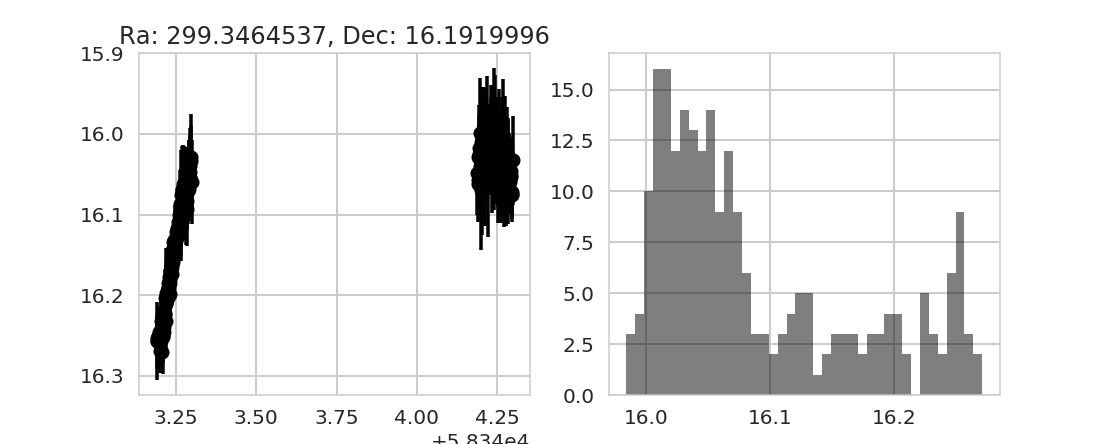

1.1451831


<IPython.core.display.Javascript object>


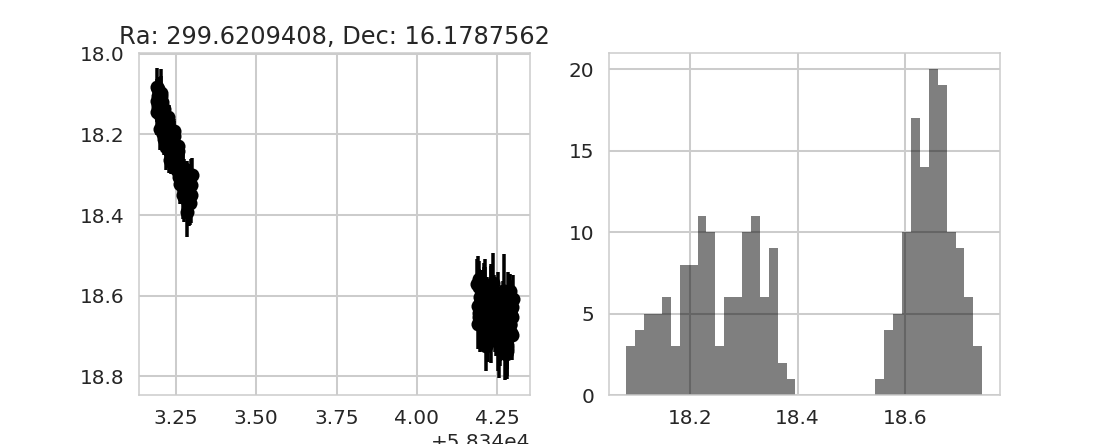

1.5169787


<IPython.core.display.Javascript object>


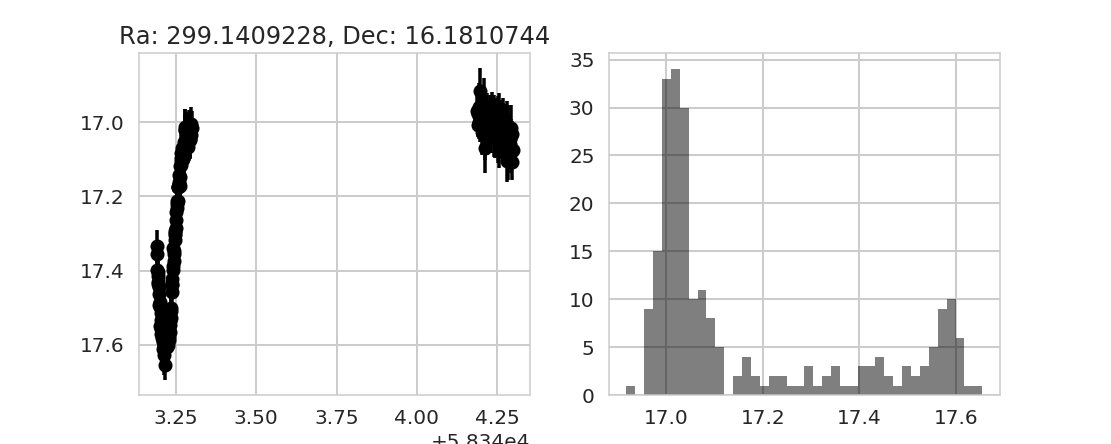

2.7335913
1.3105812


<IPython.core.display.Javascript object>


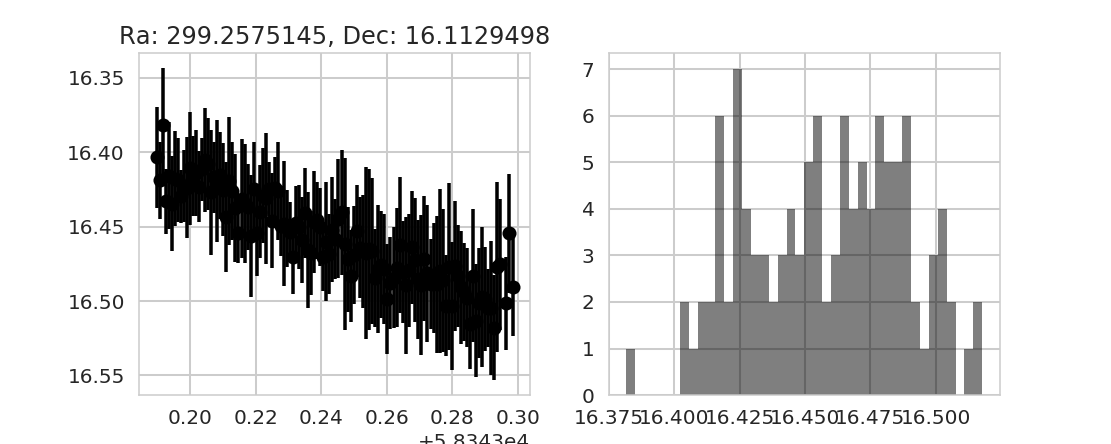

5.3408713
1.4859874


<IPython.core.display.Javascript object>


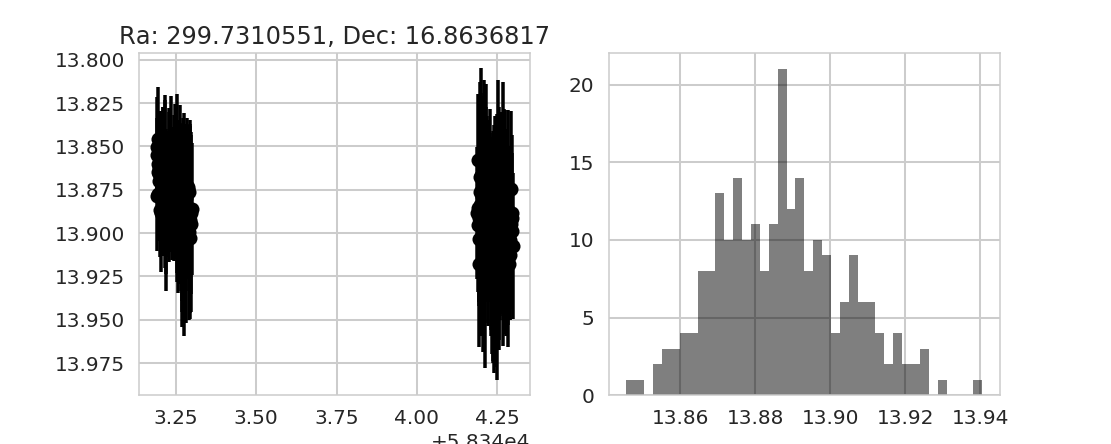

3.8896046
2.5611713
1.6561958


<IPython.core.display.Javascript object>


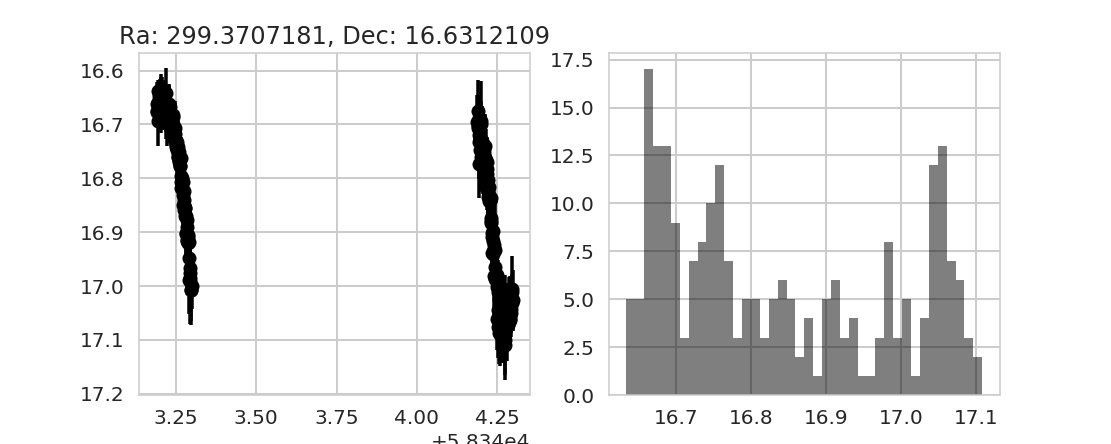

1.3440001


<IPython.core.display.Javascript object>


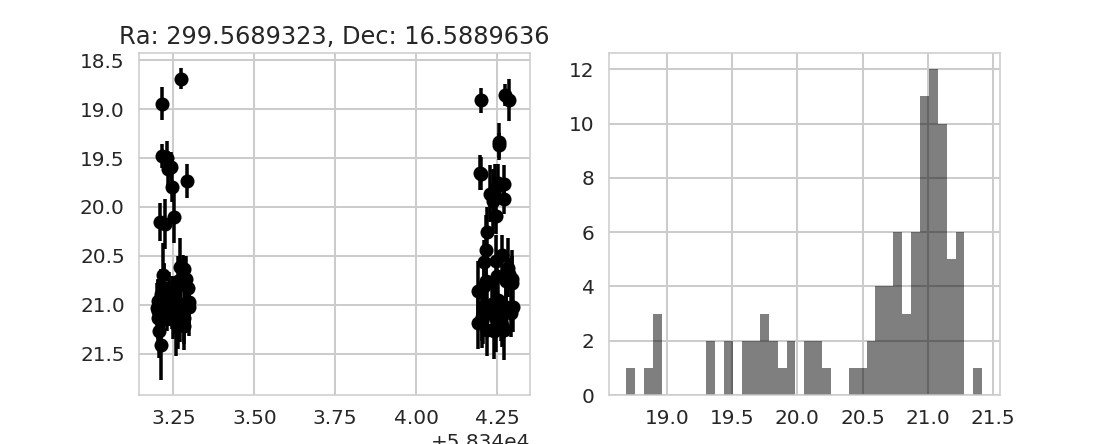

2.939408
4.265279
1.3803563


<IPython.core.display.Javascript object>


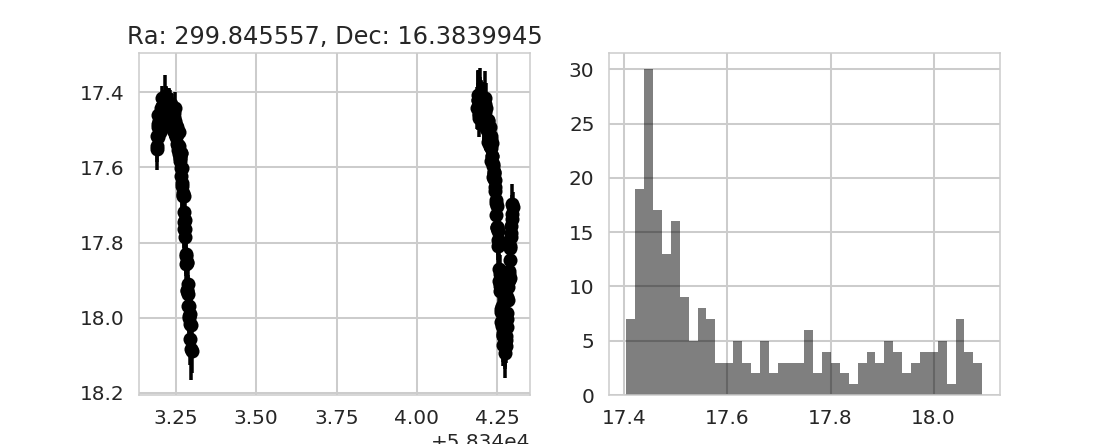

6.801502
1.5598553


<IPython.core.display.Javascript object>


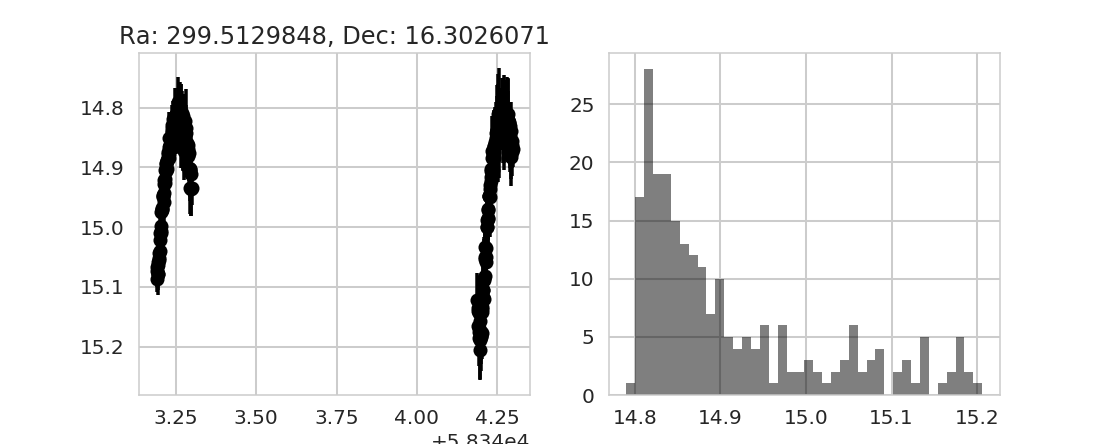

1.5799829


<IPython.core.display.Javascript object>


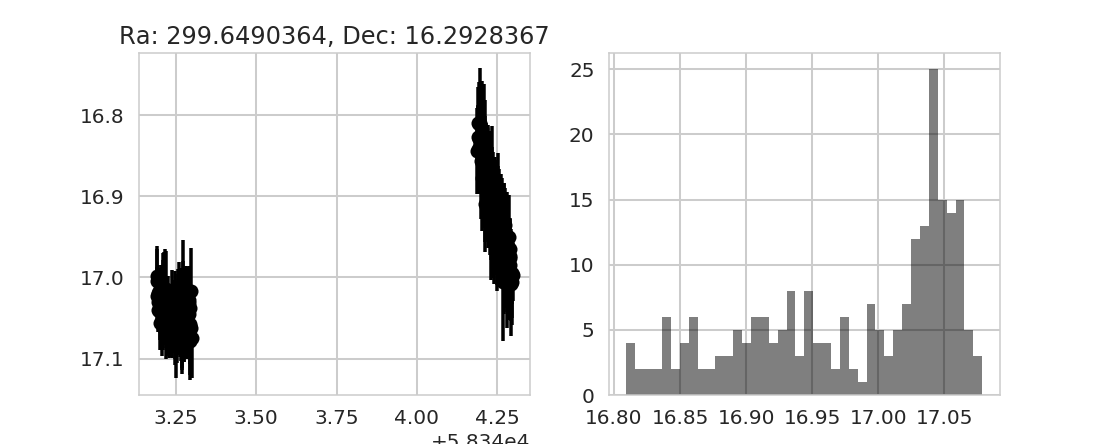

1.5689745


<IPython.core.display.Javascript object>


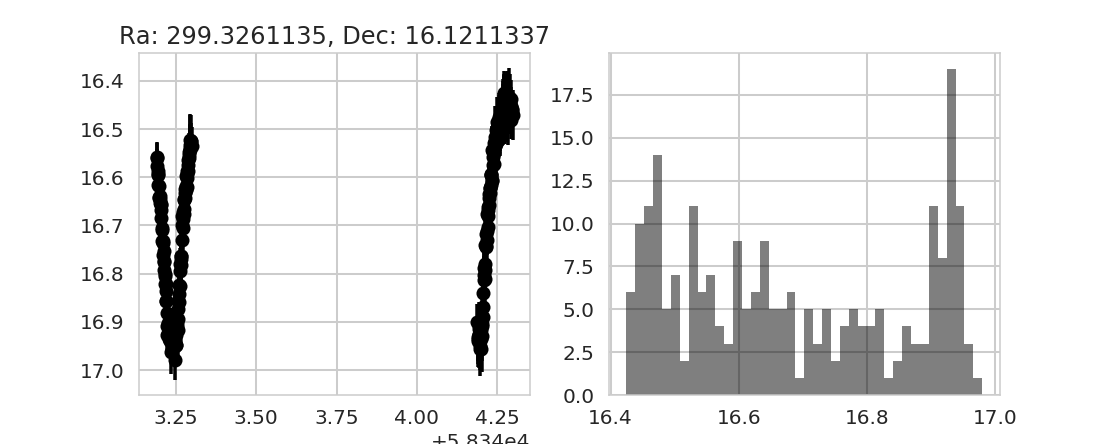

1.4804103


<IPython.core.display.Javascript object>


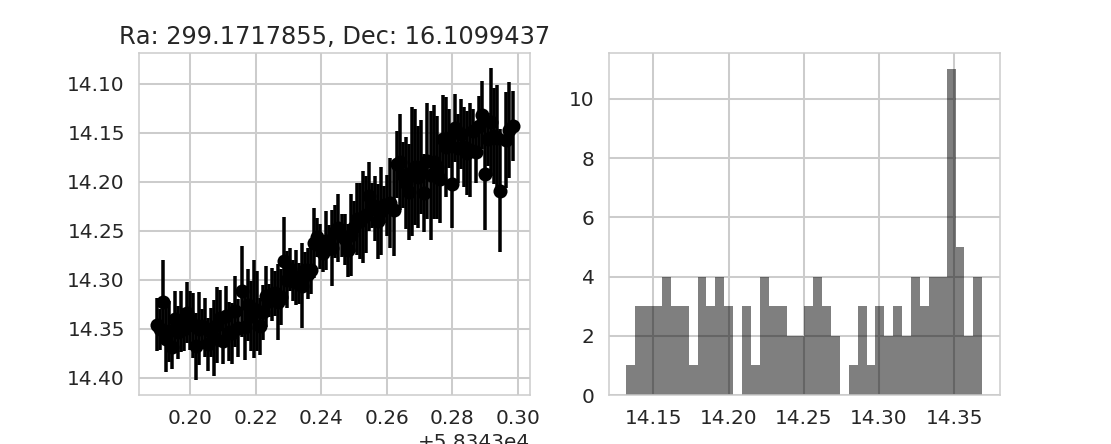

1.20336


<IPython.core.display.Javascript object>


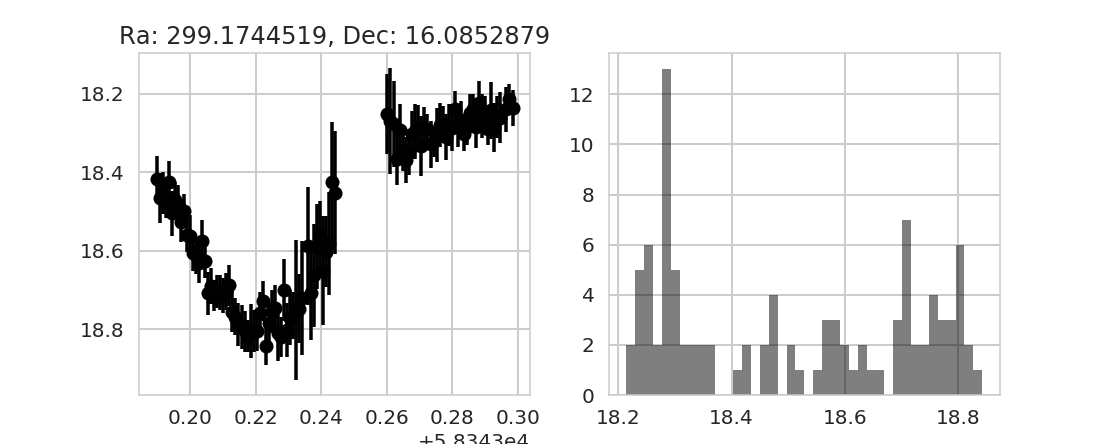

1.2193949


<IPython.core.display.Javascript object>


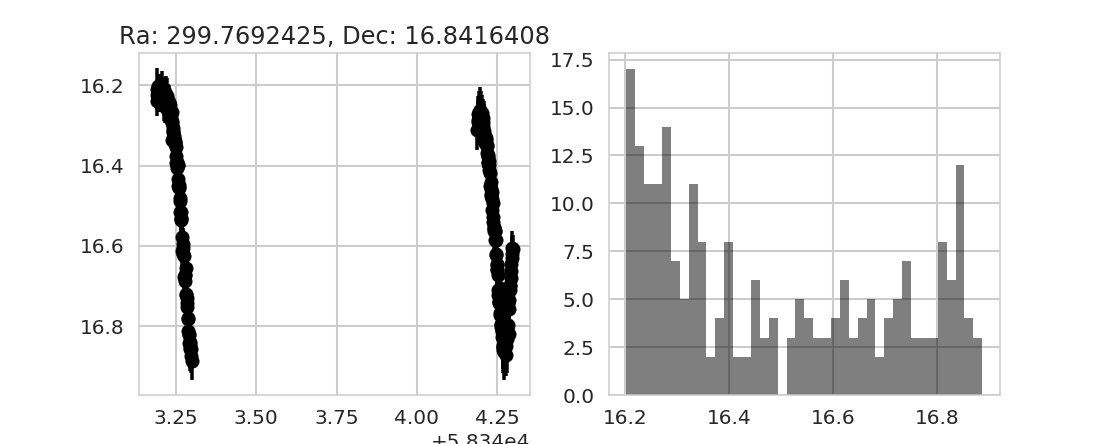

2.9764915
3.2392867
2.7921972
1.3370681


<IPython.core.display.Javascript object>


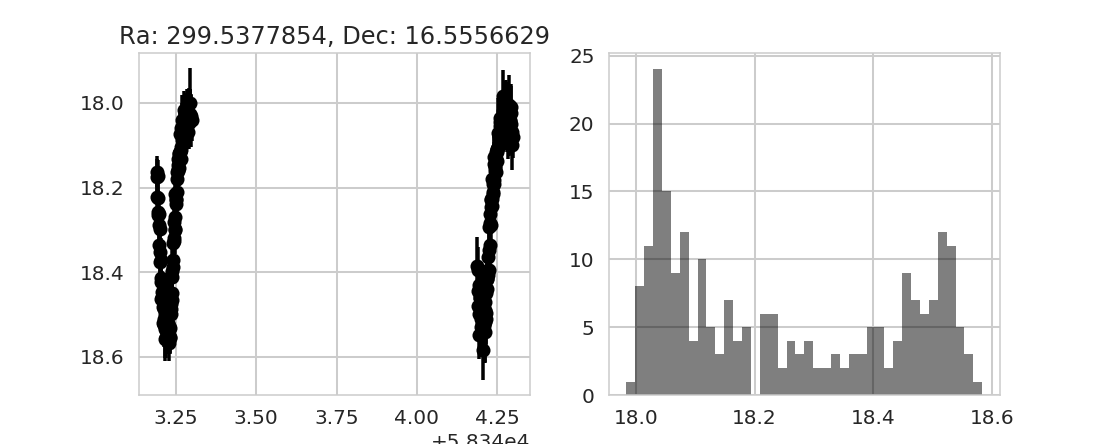

3.5579338
2.4606695
1.4133093


<IPython.core.display.Javascript object>


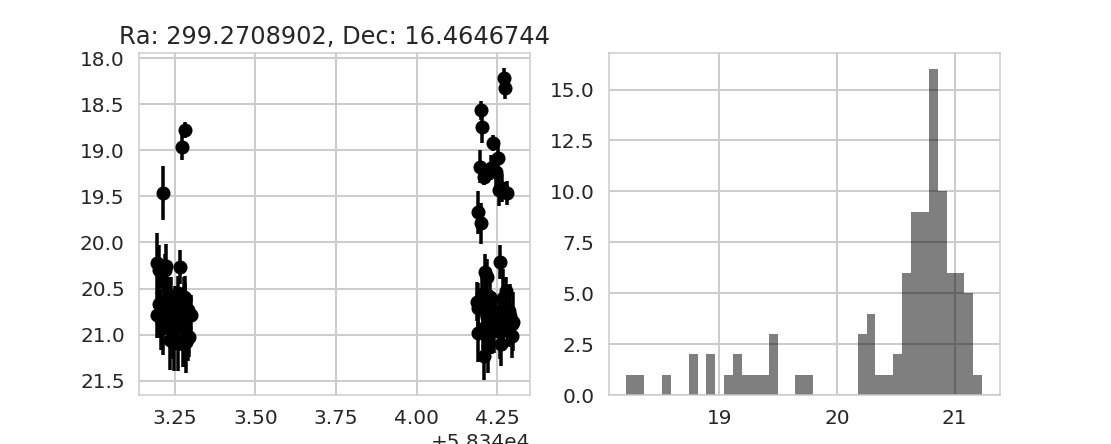

1.4991617


<IPython.core.display.Javascript object>


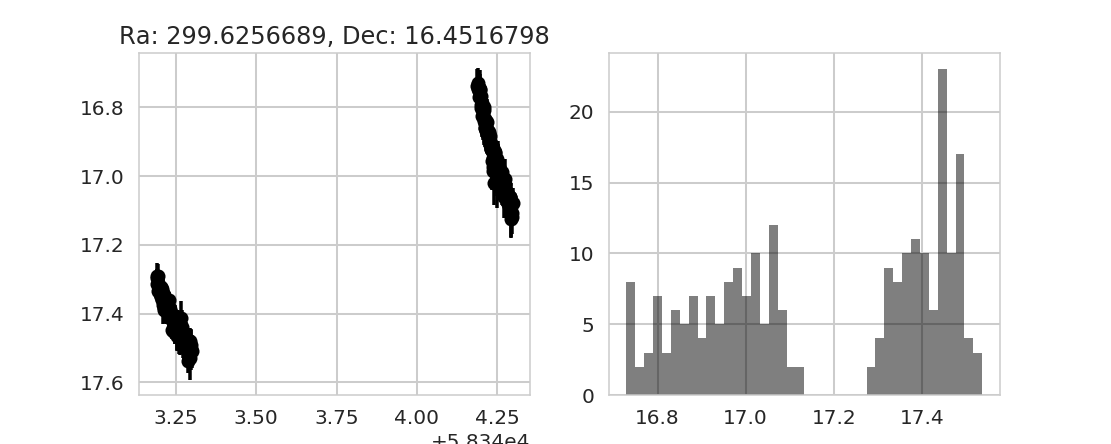

4.9489493
2.831235
3.4238372
1.5137745


<IPython.core.display.Javascript object>


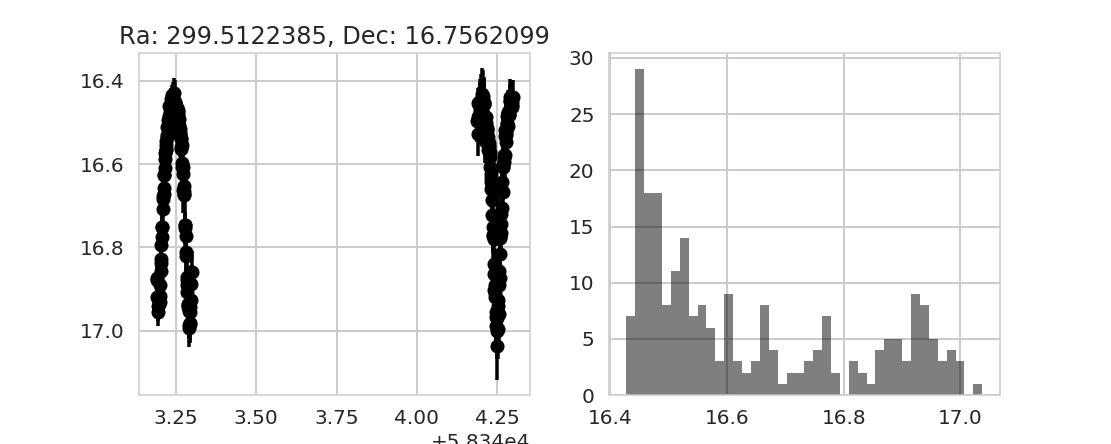

4.7357016
2.941079
2.5402555
1.6044629


<IPython.core.display.Javascript object>


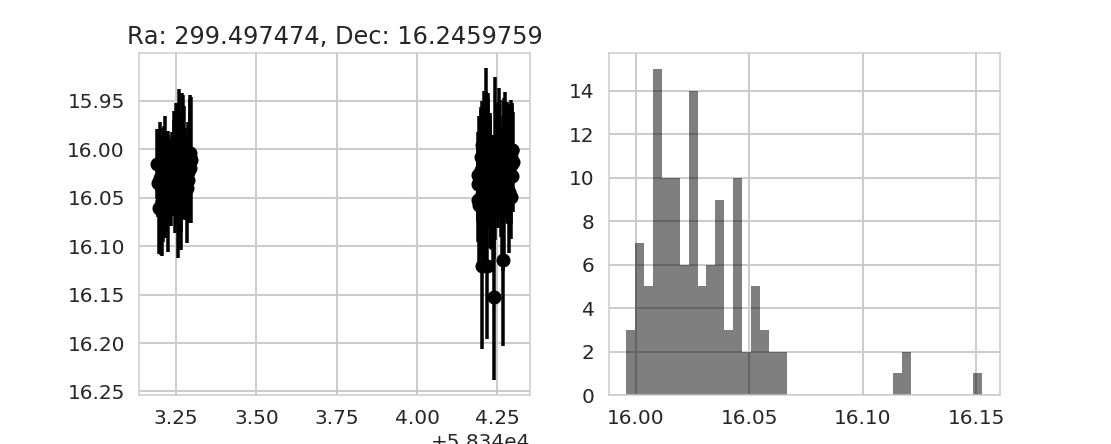

1.7911702


<IPython.core.display.Javascript object>


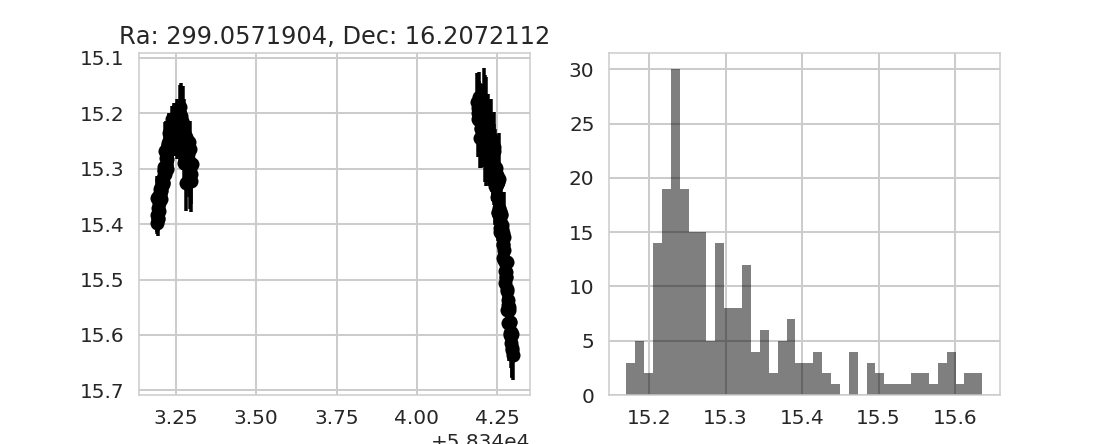

2.1615086
3.033219
3.2095234
3.9737034
3.105907
2.6213663
4.2790356
3.8236916
3.7154226
3.7208014
2.7401583
5.256051
3.704012
6.0968227
4.6102943
3.7693691
2.4185715
4.8343487
2.185647
3.0021203
2.205639
4.0129757
3.4059777


In [137]:
for mid in np.array(variables.matchid):
    s = sourcedata[sourcedata["matchid"] == mid]
    
    print(np.mean(s["chi"]))
    
    if np.mean(s["chi"]) >2 :
        continue
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        ax1.errorbar(s["mjd"], s["psfmag"], yerr=s["psfmagerr"], 
                    fmt="o", color="black");

        ax1.invert_yaxis()
        ax1.set_title("Ra: " + str(s["ra"].values[0]) + ", Dec: " + str(s["dec"].values[0]))
        ax2.hist(s["psfmag"], bins=40, histtype="stepfilled", alpha=0.5, color="black")

Let's try the Stetson-J:

Reasonable cuts:
* Stetson-j is a better cut for variability, because it'll follow the curve of the rms plot above.


In [141]:
variable_ids = np.array(sources[mask2].matchid)

In [142]:
len(variable_ids)

317

In [143]:
variable_ids

array([ 2435,  2507,  2511,  2686,  2928,  2997,  3003,  3293,  4229,
        8330,  8634, 10916, 11592, 11623, 11625, 11629, 11918, 12035,
       12549, 12745, 12966, 12992, 13162, 13277, 13283, 13301, 13341,
       13381, 13431, 13546, 13568, 13622, 13693, 13725, 13750, 13818,
       13822, 13840, 13871, 13923, 14210, 14217, 14315, 14462, 14483,
       14553, 14633, 14749, 14814, 14854, 14867, 14880, 15043, 15097,
       15112, 15302, 15371, 15391, 15400, 15435, 15498, 15540, 15582,
       15653, 15661, 15684, 15725, 15783, 15857, 15904, 15921, 15925,
       15929, 15974, 15981, 16019, 16030, 16051, 16099, 16126, 16152,
       16196, 16198, 16224, 16236, 16594, 16715, 16716, 17475, 17638,
       17639, 18061, 18389, 18846, 19247, 19248, 19253, 19616, 19892,
       19902, 19927, 19937, 20036, 20196, 20258, 21014, 21019, 21738,
       22043, 23752, 23754, 23764, 24085, 24237, 24329, 24943, 25014,
       25111, 25816, 25924, 25952, 26160, 26275, 26285, 26294, 26295,
       26296, 26304,

In [159]:
var_sources = sources.loc[variable_ids]

In [165]:
var_sources.nobs.sort_values()[::-1]

16594    164
38148    141
34691    119
30991    103
26559    102
28765     99
41805     92
29354     86
10916     82
18389     75
44376     74
19892     74
43741     72
44330     71
37937     69
40673     66
29284     66
43478     64
41035     62
19927     57
44311     56
43776     55
11625     53
42784     53
44116     53
44186     53
32044     52
20036     51
43749     50
44273     50
        ... 
16126      0
16152      0
16196      0
16198      0
16224      0
16236      0
39611      0
15783      0
15684      0
14483      0
15112      0
14553      0
14633      0
14749      0
14854      0
14867      0
14880      0
15043      0
15097      0
15302      0
15661      0
15371      0
15391      0
15400      0
15435      0
15498      0
15540      0
15582      0
15653      0
2435       0
Name: nobs, Length: 317, dtype: int64

In [171]:
mid = 38148

In [172]:
source = sourcedata[sourcedata["matchid"] == mid]

In [173]:
source.shape

(123, 24)

<IPython.core.display.Javascript object>


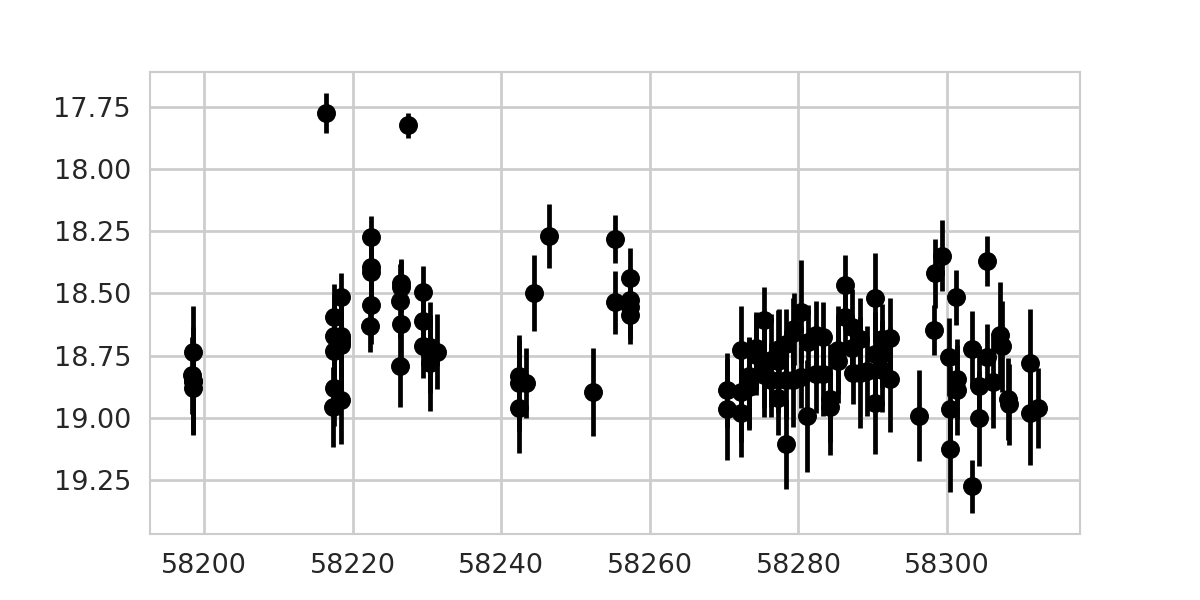

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(source["mjd"], source["psfmag"], yerr=source["psfmagerr"], 
            fmt="o", color="black");

ax.invert_yaxis()